
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain daily SLP predictor and associated wave conditions. Based on Camus et al. (2014), Hegermiller et al. (2017) and Rueda et al. (2017)


inputs required: 
  * ESTELA fields for the site location
  * SLP fields from CFSR reanalysis
  * Wave families from *notebook 09*
  * Historical TCs inside radio 14 from *notebook 05*
  
in this notebook:
  * Construct daily SLP predictor
  * Obtain Daily Weather Types (DWT) and probabilities of occurrence
  * Associate wave conditions to each DWT

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, Predictor
from teslakit.util.time_operations import xds_common_dates_daily

from teslakit.plotting.estela import Plot_ESTELA
from teslakit.plotting.wts import Plot_Probs_WT_WT, Plot_Probs_WT_WT_anomaly
from teslakit.plotting.waves import Plot_Waves_DWTs



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

ESTELA = db.Load_ESTELA_data()            # ESTELA D data
SLP = db.Load_ESTELA_SLP()                # ESTELA Sea Level Pressure

WAVES = db.Load_WAVES_hist()              # Historical gow waves point

_, TCs_r1_params = db.Load_TCs_r1_hist()  # TCs historical parameters inside 14º radius 

WAVES_runup_E = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_runup_E.nc')
WAVES_runup_S = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_runup_S.nc')
WAVES_runup_N = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_runup_N.nc')

# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-01'
kma_date_end = '2016-12-31'
num_clusters = 36
kmarg_alpha = 0.36



## ESTELA Predictor - Sea Level Pressure and Gradient

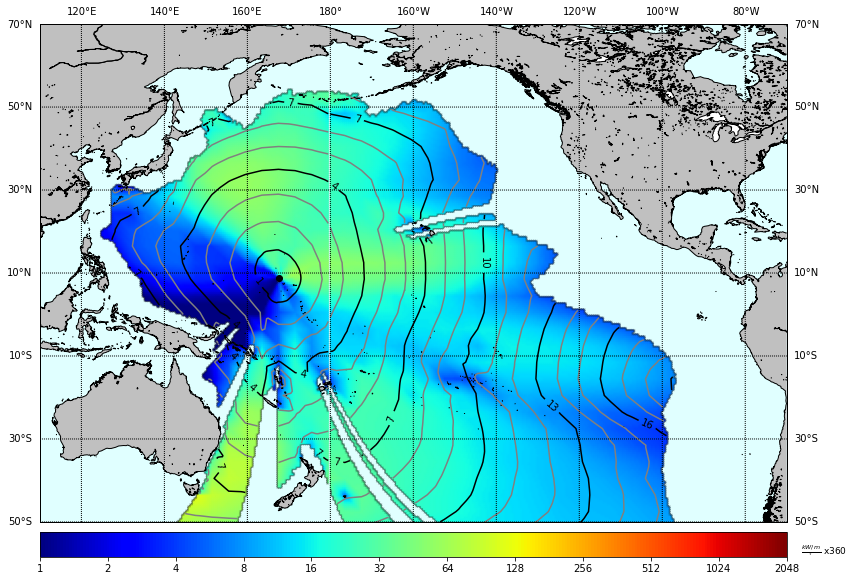

In [4]:
# --------------------------------------
# Plot ESTELA and wave point coordinates

mask_plot = ESTELA.mask_e95

Plot_ESTELA(
    ESTELA.pnt_longitude, ESTELA.pnt_latitude,
    ESTELA.F_y1993to2012 * mask_plot, 
    ESTELA.D_y1993to2012 * mask_plot,
    lon1 = 110, lon2 = 290, lat1 = -50, lat2 = 70,
);


In [4]:
# --------------------------------------
# calculate mean runup, resample to daily

# Calculate daily mean
WAVES_runup_E_daily = WAVES_runup_E.runup.resample(time='1D').mean()
WAVES_runup_S_daily = WAVES_runup_S.runup.resample(time='1D').mean()
WAVES_runup_N_daily = WAVES_runup_N.runup.resample(time='1D').mean()


# Cuando Hs o Tp, están fuera de los límites de Hycreww, no se obtiene runup (hay NaNS)
WAVES_runup_E_daily = WAVES_runup_E_daily.interpolate_na(dim=('time'), method='linear')
WAVES_runup_S_daily = WAVES_runup_S_daily.interpolate_na(dim=('time'), method='linear')
WAVES_runup_N_daily = WAVES_runup_N_daily.interpolate_na(dim=('time'), method='linear')


# select time window 
WAVES_runup_E_daily = WAVES_runup_E_daily.sel(time = slice(kma_date_ini, kma_date_end))
WAVES_runup_S_daily = WAVES_runup_S_daily.sel(time = slice(kma_date_ini, kma_date_end))
WAVES_runup_N_daily = WAVES_runup_N_daily.sel(time = slice(kma_date_ini, kma_date_end))


# mean runup from 3 points
RUNUP = (WAVES_runup_E_daily + WAVES_runup_S_daily  + WAVES_runup_N_daily)/3.0
RUNUP = RUNUP.to_dataset()    

print(RUNUP)


<xarray.Dataset>
Dimensions:  (time: 13880)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2016-12-31
Data variables:
    runup    (time) float64 2.101 2.279 2.496 2.312 ... 1.74 1.71 1.631 1.666


(725372.0, 726468.0)

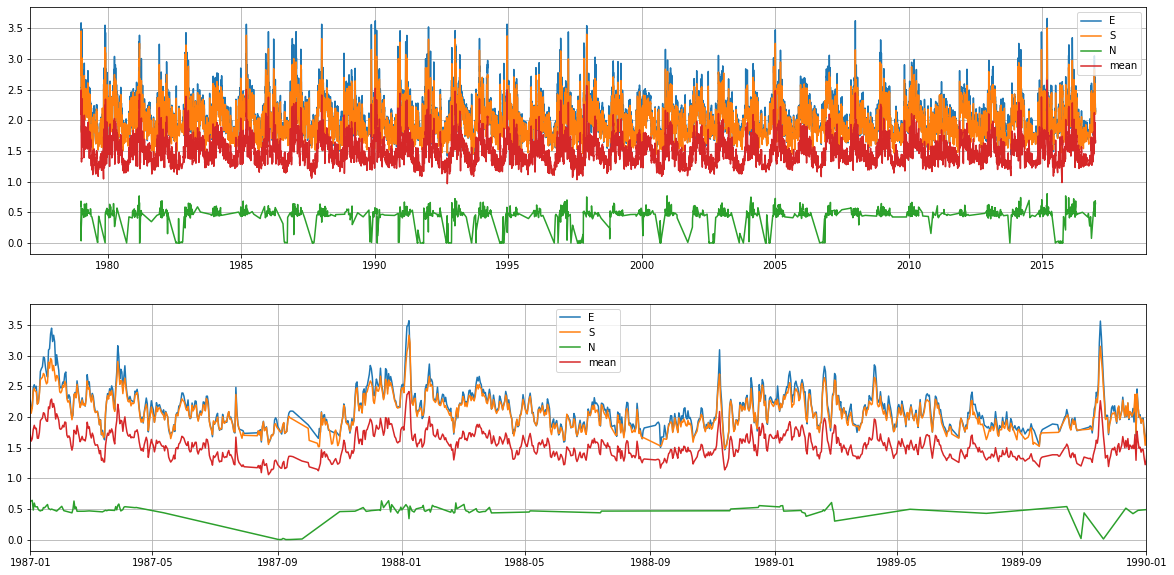

In [8]:
fig, axs = plt.subplots(2,1, figsize=(20,10))

axs[0].plot(WAVES_runup_E_daily.time, WAVES_runup_E_daily, label='E')
axs[0].plot(WAVES_runup_S_daily.time, WAVES_runup_S_daily, label='S')
axs[0].plot(WAVES_runup_N_daily.time, WAVES_runup_N_daily, label='N')
axs[0].plot(RUNUP.time, RUNUP.runup, label='mean')
axs[0].legend()
axs[0].grid()

axs[1].plot(WAVES_runup_E_daily.time, WAVES_runup_E_daily, label='E')
axs[1].plot(WAVES_runup_S_daily.time, WAVES_runup_S_daily, label='S')
axs[1].plot(WAVES_runup_N_daily.time, WAVES_runup_N_daily, label='N')
axs[1].plot(RUNUP.time, RUNUP.runup, label='mean')
axs[1].legend()
axs[1].grid()
axs[1].set_xlim(datetime.datetime(1987,1,1),datetime.datetime(1990,1,1))


In [9]:
# --------------------------------------
# Calculate site SLP & SLP_gradient (daily)

# select time window and do data daily mean
SLP_d = SLP.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()

# calculate daily gradients
SLP_d = spatial_gradient(SLP_d, 'SLP')

print(SLP_d)
    

<xarray.Dataset>
Dimensions:       (latitude: 80, longitude: 96, time: 13880)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2016-12-31
  * latitude      (latitude) float32 80.0 78.0 76.0 74.0 ... -74.0 -76.0 -78.0
  * longitude     (longitude) float32 100.0 102.0 104.0 ... 286.0 288.0 290.0
Data variables:
    SLP           (time, latitude, longitude) float64 9.946e+04 ... 9.906e+04
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0



## ESTELA Predictor - Principal Component Analysis

In [10]:
# --------------------------------------
# remove sectors from which waves do not arrive to site
# W=0º, N=-90º, W=180º, S=90º

def cart2pol(a, b):
    '''Output in degrees'''
    # convert to geographic convention
    module = np.sqrt(a**2 + b**2)
    direction = np.arctan2(b, a)
    direction = np.degrees(direction)

    return module, direction


[lon, lat] = np.meshgrid(SLP_d.longitude, SLP_d.latitude)

[mod,dire] = cart2pol(167.735-lon, 8.705-lat)

mask1 = np.where((dire>=65), 1, -1) # keep from SW to E
mask2 = np.where((dire<=-135), 1, -1) # keep from NE to E

mask = - (mask1*mask2)
mask = np.where(mask==1, 1, np.nan)

SLP_d['SLP'] = SLP_d.SLP * mask
SLP_d['SLP_gradient'] = SLP_d.SLP_gradient * mask



In [11]:
# --------------------------------------
# Calculate ESTELA PCA

# select ESTELA at site grid
ESTELA_site = ESTELA.sel(longitude = SLP.longitude, latitude = SLP.latitude)
estela_D = ESTELA_site.D_y1993to2012

# estela masks: data mask (95% energy) and land mask (plots)
estela_mask = ESTELA_site.mask_e95  
estela_land = ESTELA_site.mask_land

# apply ESTELA mask to SLP data
SLP_d['SLP'] = SLP_d.SLP * estela_mask
SLP_d['SLP_gradient'] = SLP_d.SLP_gradient * estela_mask
SLP_d['mask_land'] = estela_land

# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = SLP_d

# PCA (dynamic estela predictor)
pred.Calc_PCA_EstelaPred('SLP', estela_D)

# Load predictor PCA, KMA
#pred.Load()

print(pred.PCA)


<xarray.Dataset>
Dimensions:        (n_components: 3626, n_features: 3626, n_lat: 80, n_lon: 96, n_points: 15360, time: 13858)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 51.38 7.264 ... 6.773e-05
    EOFs           (n_components, n_features) float64 0.002022 ... -0.0001613
    variance       (n_components) float64 436.3 207.0 ... 6.793e-09 3.999e-09
    pred_mean      (n_features) float64 9.927e+04 9.969e+04 ... 2.83e+05
    pred_std       (n_features) float64 1.212e+03 1.208e+03 ... 2.086e+05
    pred_lon       (n_lon) float64 100.0 102.0 104.0 106.0 ... 286.0 288.0 290.0
    pred_lat       (n_lat) float64 80.0 78.0 76.0 74.0 ... -74.0 -76.0 -78.0
    pred_time      (time) datetime64[ns] 1979-01-23 1979-01-24 ... 2016-12-31
    pred_data_pos  (n_points) bool False False False False ... False False False
Attributes:
    method:     gradient + estela
    pred_name:  SLP


<xarray.Dataset>
Dimensions:        (n_components: 3626, n_features: 3626, n_lat: 80, n_lon: 96, n_points: 15360, time: 13858)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 51.38 7.264 ... 6.773e-05
    EOFs           (n_components, n_features) float64 0.002022 ... -0.0001613
    variance       (n_components) float64 436.3 207.0 ... 6.793e-09 3.999e-09
    pred_mean      (n_features) float64 9.927e+04 9.969e+04 ... 2.83e+05
    pred_std       (n_features) float64 1.212e+03 1.208e+03 ... 2.086e+05
    pred_lon       (n_lon) float64 100.0 102.0 104.0 106.0 ... 286.0 288.0 290.0
    pred_lat       (n_lat) float64 80.0 78.0 76.0 74.0 ... -74.0 -76.0 -78.0
    pred_time      (time) datetime64[ns] 1979-01-23 1979-01-24 ... 2016-12-31
    pred_data_pos  (n_points) bool False False False False ... False False False
Attributes:
    method:     gradient + estela
    pred_name:  SLP


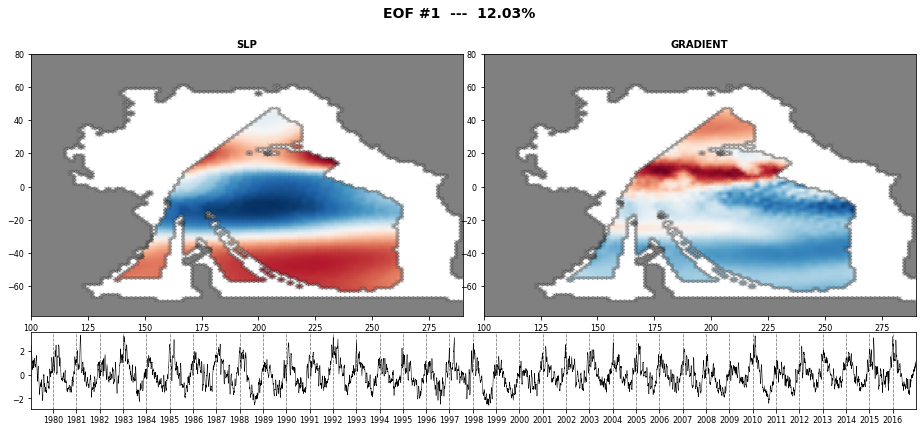

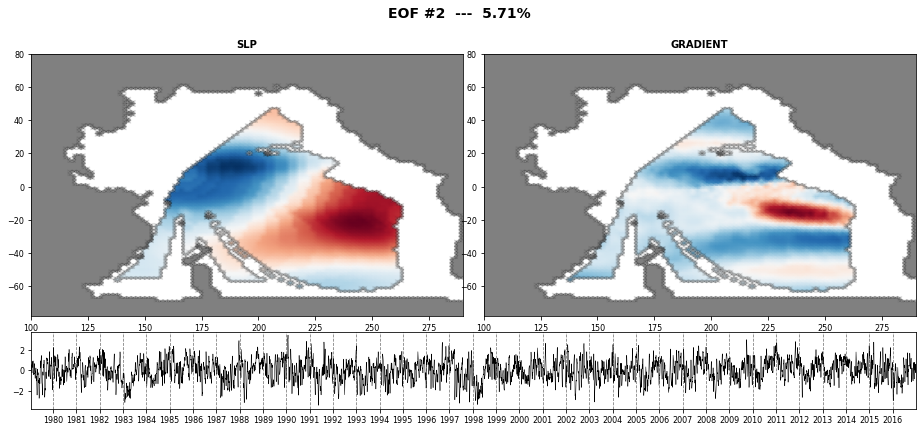

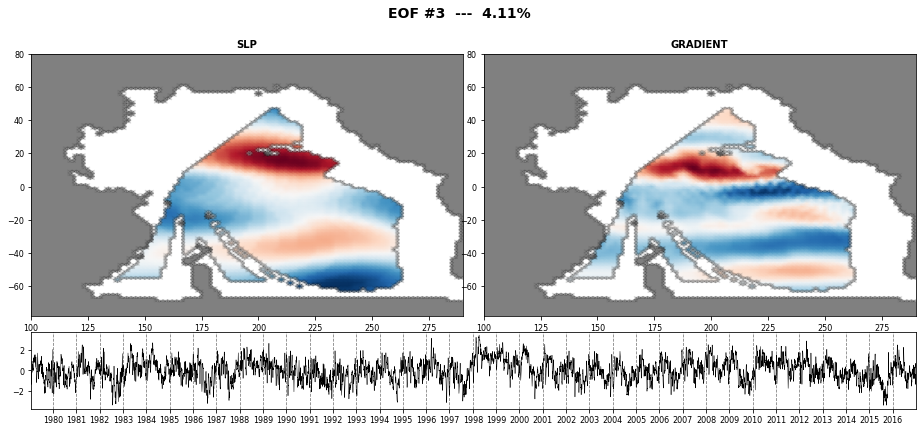

In [12]:
# plot PCA EOFs
n_EOFs = 3

pred.Plot_EOFs_EstelaPred(n_EOFs, show=True);



## ESTELA Predictor - KMeans Classification

In [13]:
# Calculate KMA (regression guided with RUNUP data)
pred.Calc_KMA_regressionguided(
    num_clusters,
    RUNUP, ['runup'],
    kmarg_alpha, min_group_size=50, repres = 0.8
)

print(pred.KMA)

  c: 1 - s: 6
  c: 2 - s: 6
  c: 6 - s: 17
  c: 7 - s: 16
  c: 17 - s: 22
  c: 19 - s: 7
  c: 25 - s: 9
  c: 31 - s: 7
  c: 32 - s: 20
  c: 34 - s: 11
total attemps:  1

  c: 3 - s: 35
  c: 8 - s: 43
  c: 10 - s: 3
  c: 14 - s: 20
  c: 15 - s: 10
  c: 24 - s: 12
  c: 35 - s: 16
total attemps:  2

  c: 11 - s: 26
  c: 12 - s: 17
  c: 24 - s: 8
  c: 26 - s: 4
  c: 33 - s: 40
  c: 34 - s: 3
total attemps:  3

  c: 0 - s: 6
  c: 3 - s: 48
  c: 8 - s: 6
  c: 10 - s: 12
  c: 19 - s: 35
  c: 20 - s: 23
  c: 26 - s: 3
  c: 27 - s: 15
  c: 30 - s: 17
  c: 31 - s: 4
total attemps:  4

  c: 17 - s: 7
  c: 19 - s: 30
  c: 22 - s: 48
  c: 26 - s: 20
  c: 34 - s: 15
total attemps:  5

  c: 0 - s: 29
  c: 2 - s: 10
  c: 13 - s: 27
  c: 15 - s: 7
  c: 27 - s: 16
  c: 28 - s: 3
  c: 32 - s: 28
  c: 33 - s: 12
total attemps:  6

  c: 0 - s: 26
  c: 2 - s: 7
  c: 10 - s: 10
  c: 11 - s: 18
  c: 13 - s: 5
  c: 16 - s: 12
  c: 19 - s: 12
  c: 20 - s: 19
  c: 23 - s: 7
  c: 25 - s: 9
  c: 30 - s: 7
  c: 31 

  c: 2 - s: 19
  c: 9 - s: 39
  c: 35 - s: 26
total attemps:  61

  c: 0 - s: 6
  c: 5 - s: 14
  c: 8 - s: 5
  c: 10 - s: 2
  c: 15 - s: 12
  c: 19 - s: 4
  c: 20 - s: 11
  c: 21 - s: 10
  c: 25 - s: 8
  c: 28 - s: 8
  c: 35 - s: 41
total attemps:  62

  c: 6 - s: 20
  c: 7 - s: 3
  c: 18 - s: 49
  c: 23 - s: 3
  c: 25 - s: 15
  c: 26 - s: 9
  c: 28 - s: 5
  c: 31 - s: 12
total attemps:  63

  c: 1 - s: 3
  c: 11 - s: 21
  c: 16 - s: 14
  c: 24 - s: 16
  c: 26 - s: 33
  c: 27 - s: 8
total attemps:  64

  c: 18 - s: 20
  c: 26 - s: 30
total attemps:  65

  c: 0 - s: 3
  c: 6 - s: 3
  c: 18 - s: 5
  c: 22 - s: 13
  c: 24 - s: 6
  c: 34 - s: 3
  c: 35 - s: 6
total attemps:  66

  c: 22 - s: 36
  c: 26 - s: 46
  c: 29 - s: 24
  c: 32 - s: 27
total attemps:  67

  c: 5 - s: 22
  c: 15 - s: 10
  c: 18 - s: 4
  c: 22 - s: 9
  c: 24 - s: 26
  c: 31 - s: 28
  c: 32 - s: 7
  c: 33 - s: 4
  c: 35 - s: 3
total attemps:  68

  c: 4 - s: 12
  c: 15 - s: 11
  c: 17 - s: 11
  c: 29 - s: 19
  c: 34 - s

  c: 3 - s: 49
  c: 11 - s: 15
  c: 13 - s: 7
  c: 20 - s: 4
  c: 30 - s: 5
  c: 31 - s: 5
  c: 33 - s: 5
  c: 35 - s: 4
total attemps:  124

  c: 7 - s: 11
  c: 18 - s: 6
  c: 22 - s: 12
  c: 23 - s: 7
  c: 25 - s: 47
  c: 34 - s: 5
  c: 35 - s: 45
total attemps:  125

  c: 2 - s: 14
  c: 10 - s: 17
  c: 16 - s: 7
  c: 21 - s: 32
  c: 22 - s: 45
  c: 27 - s: 17
  c: 30 - s: 17
  c: 33 - s: 13
total attemps:  126

  c: 2 - s: 9
  c: 9 - s: 5
  c: 14 - s: 4
  c: 15 - s: 9
  c: 16 - s: 10
  c: 20 - s: 40
  c: 21 - s: 4
  c: 22 - s: 4
  c: 25 - s: 5
  c: 28 - s: 19
  c: 30 - s: 12
total attemps:  127

  c: 0 - s: 12
  c: 2 - s: 37
  c: 5 - s: 8
  c: 7 - s: 9
  c: 8 - s: 31
  c: 12 - s: 15
  c: 13 - s: 4
  c: 16 - s: 4
  c: 17 - s: 4
  c: 23 - s: 6
  c: 25 - s: 4
  c: 30 - s: 8
  c: 34 - s: 6
total attemps:  128

  c: 7 - s: 28
  c: 13 - s: 13
  c: 18 - s: 5
  c: 19 - s: 11
  c: 22 - s: 12
  c: 25 - s: 16
  c: 32 - s: 19
  c: 33 - s: 22
  c: 35 - s: 45
total attemps:  129

  c: 7 - s: 17
 

  c: 0 - s: 3
  c: 2 - s: 4
  c: 10 - s: 8
  c: 14 - s: 19
  c: 17 - s: 14
  c: 22 - s: 28
  c: 30 - s: 16
  c: 32 - s: 15
  c: 33 - s: 8
  c: 35 - s: 13
total attemps:  184

  c: 2 - s: 12
  c: 15 - s: 20
  c: 16 - s: 32
  c: 18 - s: 6
  c: 21 - s: 7
  c: 24 - s: 10
  c: 25 - s: 13
  c: 26 - s: 24
  c: 29 - s: 12
  c: 30 - s: 3
  c: 35 - s: 19
total attemps:  185

  c: 3 - s: 19
  c: 17 - s: 10
  c: 27 - s: 8
  c: 29 - s: 9
  c: 31 - s: 18
  c: 33 - s: 3
  c: 34 - s: 46
total attemps:  186

  c: 0 - s: 5
  c: 11 - s: 21
  c: 24 - s: 24
  c: 35 - s: 45
total attemps:  187

  c: 1 - s: 23
  c: 3 - s: 16
  c: 5 - s: 39
  c: 6 - s: 28
  c: 9 - s: 5
  c: 30 - s: 20
total attemps:  188

  c: 10 - s: 8
  c: 12 - s: 13
  c: 20 - s: 31
  c: 27 - s: 42
  c: 29 - s: 16
  c: 32 - s: 7
  c: 34 - s: 3
total attemps:  189

  c: 13 - s: 25
  c: 18 - s: 6
  c: 24 - s: 7
  c: 28 - s: 6
  c: 32 - s: 7
  c: 33 - s: 7
total attemps:  190

  c: 5 - s: 14
  c: 11 - s: 6
  c: 18 - s: 20
  c: 22 - s: 36
  c: 

  c: 2 - s: 16
  c: 12 - s: 6
  c: 14 - s: 8
  c: 19 - s: 10
  c: 22 - s: 6
  c: 28 - s: 4
  c: 29 - s: 27
  c: 34 - s: 5
  c: 35 - s: 5
total attemps:  245

  c: 4 - s: 8
  c: 9 - s: 39
  c: 14 - s: 15
  c: 17 - s: 4
  c: 20 - s: 5
  c: 29 - s: 8
  c: 33 - s: 9
total attemps:  246

  c: 5 - s: 2
  c: 11 - s: 6
  c: 12 - s: 17
  c: 15 - s: 13
  c: 19 - s: 6
  c: 23 - s: 8
  c: 26 - s: 3
  c: 29 - s: 3
  c: 31 - s: 5
  c: 32 - s: 14
total attemps:  247

  c: 13 - s: 14
  c: 15 - s: 15
  c: 23 - s: 7
  c: 27 - s: 5
  c: 30 - s: 15
  c: 31 - s: 3
  c: 32 - s: 18
total attemps:  248

  c: 0 - s: 18
  c: 17 - s: 21
  c: 18 - s: 11
  c: 19 - s: 7
  c: 23 - s: 30
  c: 28 - s: 19
  c: 30 - s: 6
  c: 33 - s: 22
total attemps:  249

  c: 9 - s: 6
  c: 14 - s: 3
  c: 19 - s: 23
  c: 21 - s: 28
  c: 25 - s: 15
  c: 26 - s: 4
  c: 27 - s: 15
total attemps:  250

  c: 8 - s: 17
  c: 12 - s: 6
  c: 24 - s: 14
  c: 26 - s: 15
  c: 27 - s: 8
  c: 28 - s: 14
  c: 34 - s: 5
total attemps:  251

  c: 0 - 

  c: 2 - s: 7
  c: 18 - s: 40
  c: 19 - s: 21
  c: 21 - s: 4
  c: 25 - s: 10
  c: 31 - s: 7
  c: 32 - s: 15
  c: 35 - s: 8
total attemps:  307

  c: 1 - s: 5
  c: 9 - s: 27
  c: 20 - s: 11
  c: 21 - s: 16
  c: 26 - s: 16
  c: 30 - s: 21
  c: 31 - s: 34
total attemps:  308

  c: 8 - s: 5
  c: 13 - s: 45
  c: 14 - s: 43
total attemps:  309

  c: 4 - s: 5
  c: 12 - s: 4
  c: 13 - s: 14
  c: 20 - s: 42
  c: 22 - s: 13
  c: 27 - s: 11
  c: 31 - s: 13
  c: 34 - s: 23
  c: 35 - s: 42
total attemps:  310

  c: 6 - s: 35
  c: 18 - s: 4
  c: 20 - s: 10
  c: 22 - s: 9
  c: 23 - s: 14
  c: 26 - s: 16
  c: 27 - s: 6
  c: 30 - s: 40
  c: 35 - s: 6
total attemps:  311

  c: 5 - s: 5
  c: 7 - s: 45
  c: 17 - s: 8
  c: 20 - s: 16
total attemps:  312

  c: 10 - s: 4
  c: 11 - s: 4
  c: 16 - s: 18
  c: 17 - s: 5
  c: 23 - s: 5
total attemps:  313

  c: 11 - s: 5
  c: 14 - s: 5
  c: 19 - s: 8
  c: 24 - s: 15
total attemps:  314

  c: 0 - s: 10
  c: 10 - s: 39
  c: 12 - s: 14
  c: 20 - s: 28
  c: 26 - s: 2

  c: 5 - s: 17
  c: 11 - s: 7
  c: 12 - s: 5
  c: 14 - s: 4
  c: 16 - s: 32
  c: 17 - s: 17
  c: 19 - s: 17
  c: 20 - s: 18
  c: 28 - s: 2
  c: 32 - s: 5
total attemps:  368

  c: 2 - s: 3
  c: 10 - s: 22
  c: 16 - s: 42
  c: 25 - s: 3
  c: 32 - s: 43
  c: 33 - s: 33
total attemps:  369

  c: 15 - s: 21
  c: 19 - s: 13
  c: 22 - s: 12
  c: 27 - s: 6
  c: 29 - s: 3
  c: 30 - s: 7
  c: 34 - s: 7
  c: 35 - s: 10
total attemps:  370

  c: 11 - s: 21
  c: 13 - s: 11
  c: 16 - s: 12
  c: 17 - s: 15
  c: 19 - s: 30
  c: 22 - s: 5
  c: 24 - s: 9
  c: 25 - s: 8
  c: 26 - s: 34
  c: 33 - s: 17
total attemps:  371

  c: 0 - s: 28
  c: 11 - s: 3
  c: 15 - s: 38
  c: 22 - s: 19
total attemps:  372

  c: 5 - s: 31
  c: 16 - s: 20
  c: 19 - s: 13
  c: 25 - s: 37
total attemps:  373

  c: 9 - s: 2
  c: 15 - s: 7
  c: 16 - s: 4
  c: 24 - s: 25
  c: 30 - s: 16
  c: 31 - s: 7
  c: 32 - s: 14
  c: 33 - s: 3
total attemps:  374

  c: 4 - s: 9
  c: 15 - s: 40
  c: 18 - s: 29
  c: 21 - s: 4
  c: 22 - s: 42
 

  c: 0 - s: 21
  c: 13 - s: 9
  c: 20 - s: 15
  c: 28 - s: 3
  c: 31 - s: 5
  c: 34 - s: 21
total attemps:  432

  c: 6 - s: 43
  c: 12 - s: 48
  c: 16 - s: 8
  c: 17 - s: 32
  c: 18 - s: 39
  c: 19 - s: 39
  c: 20 - s: 3
  c: 23 - s: 14
  c: 29 - s: 11
  c: 35 - s: 10
total attemps:  433

  c: 4 - s: 15
  c: 10 - s: 3
  c: 13 - s: 4
  c: 22 - s: 3
  c: 26 - s: 16
  c: 30 - s: 32
  c: 32 - s: 43
  c: 33 - s: 4
  c: 34 - s: 3
total attemps:  434

  c: 7 - s: 10
  c: 8 - s: 9
  c: 11 - s: 5
  c: 12 - s: 41
  c: 13 - s: 4
  c: 16 - s: 5
  c: 19 - s: 15
  c: 22 - s: 20
  c: 24 - s: 6
  c: 29 - s: 27
total attemps:  435

  c: 6 - s: 4
  c: 7 - s: 6
  c: 9 - s: 9
  c: 15 - s: 39
  c: 18 - s: 6
  c: 21 - s: 12
  c: 28 - s: 5
  c: 32 - s: 29
total attemps:  436

  c: 20 - s: 33
  c: 25 - s: 6
  c: 27 - s: 19
total attemps:  437

  c: 1 - s: 18
  c: 6 - s: 13
  c: 14 - s: 4
  c: 19 - s: 13
  c: 21 - s: 20
  c: 23 - s: 32
  c: 30 - s: 18
  c: 32 - s: 11
  c: 34 - s: 4
total attemps:  438

  c: 1

  c: 0 - s: 41
  c: 8 - s: 9
  c: 15 - s: 4
  c: 22 - s: 7
  c: 29 - s: 16
  c: 33 - s: 16
  c: 35 - s: 8
total attemps:  495

  c: 8 - s: 47
  c: 10 - s: 5
  c: 16 - s: 6
  c: 19 - s: 19
  c: 20 - s: 22
  c: 25 - s: 8
  c: 30 - s: 7
  c: 32 - s: 5
total attemps:  496

  c: 4 - s: 35
  c: 7 - s: 11
  c: 9 - s: 27
  c: 14 - s: 20
  c: 20 - s: 49
  c: 21 - s: 16
  c: 24 - s: 8
  c: 27 - s: 31
  c: 29 - s: 6
  c: 35 - s: 14
total attemps:  497

  c: 2 - s: 12
  c: 10 - s: 6
  c: 18 - s: 3
  c: 19 - s: 23
  c: 20 - s: 36
  c: 30 - s: 6
  c: 32 - s: 11
  c: 33 - s: 11
  c: 35 - s: 23
total attemps:  498

  c: 13 - s: 8
  c: 15 - s: 3
  c: 26 - s: 30
  c: 27 - s: 4
total attemps:  499

  c: 10 - s: 26
  c: 12 - s: 11
  c: 20 - s: 28
  c: 21 - s: 29
  c: 29 - s: 10
  c: 31 - s: 21
  c: 33 - s: 31
  c: 34 - s: 26
total attemps:  500

  c: 0 - s: 37
  c: 15 - s: 35
  c: 16 - s: 6
  c: 17 - s: 5
  c: 20 - s: 10
  c: 21 - s: 7
  c: 22 - s: 5
  c: 28 - s: 9
  c: 29 - s: 6
  c: 33 - s: 36
total att

  c: 2 - s: 18
  c: 17 - s: 5
  c: 27 - s: 7
  c: 31 - s: 10
  c: 32 - s: 5
  c: 33 - s: 26
total attemps:  557

  c: 7 - s: 10
  c: 17 - s: 13
  c: 18 - s: 20
  c: 19 - s: 13
  c: 23 - s: 3
  c: 33 - s: 30
total attemps:  558

  c: 8 - s: 28
  c: 9 - s: 6
  c: 15 - s: 46
  c: 16 - s: 13
  c: 23 - s: 5
  c: 25 - s: 8
  c: 26 - s: 8
  c: 28 - s: 11
  c: 31 - s: 21
  c: 34 - s: 9
  c: 35 - s: 16
total attemps:  559

  c: 8 - s: 3
  c: 9 - s: 19
  c: 10 - s: 6
  c: 22 - s: 4
  c: 23 - s: 7
  c: 24 - s: 11
  c: 27 - s: 20
  c: 29 - s: 3
  c: 32 - s: 3
total attemps:  560

  c: 13 - s: 22
  c: 16 - s: 16
  c: 28 - s: 28
  c: 31 - s: 23
  c: 33 - s: 27
total attemps:  561

  c: 1 - s: 10
  c: 18 - s: 10
  c: 23 - s: 22
  c: 27 - s: 14
  c: 29 - s: 8
total attemps:  562

  c: 7 - s: 32
  c: 9 - s: 43
  c: 11 - s: 6
  c: 12 - s: 10
  c: 26 - s: 14
  c: 28 - s: 3
  c: 29 - s: 43
total attemps:  563

  c: 5 - s: 9
  c: 6 - s: 14
  c: 9 - s: 12
  c: 12 - s: 5
  c: 13 - s: 10
  c: 17 - s: 10
  c: 

  c: 8 - s: 4
  c: 17 - s: 14
  c: 19 - s: 7
  c: 23 - s: 5
  c: 24 - s: 14
  c: 30 - s: 7
  c: 34 - s: 17
total attemps:  616

  c: 0 - s: 12
  c: 10 - s: 18
  c: 12 - s: 3
  c: 14 - s: 3
  c: 17 - s: 13
  c: 19 - s: 20
  c: 24 - s: 7
  c: 25 - s: 17
  c: 26 - s: 6
  c: 29 - s: 14
total attemps:  617

  c: 1 - s: 11
  c: 9 - s: 21
  c: 12 - s: 3
  c: 15 - s: 7
  c: 17 - s: 7
  c: 24 - s: 6
  c: 25 - s: 5
  c: 31 - s: 47
  c: 33 - s: 3
total attemps:  618

  c: 0 - s: 5
  c: 4 - s: 8
  c: 12 - s: 8
  c: 14 - s: 22
  c: 18 - s: 6
  c: 19 - s: 5
  c: 20 - s: 8
  c: 23 - s: 9
  c: 27 - s: 13
  c: 31 - s: 8
  c: 35 - s: 5
total attemps:  619

  c: 5 - s: 4
  c: 13 - s: 10
  c: 16 - s: 6
  c: 20 - s: 7
  c: 22 - s: 16
  c: 34 - s: 17
total attemps:  620

  c: 11 - s: 35
  c: 12 - s: 10
  c: 18 - s: 10
  c: 22 - s: 10
  c: 32 - s: 10
total attemps:  621

  c: 5 - s: 3
  c: 17 - s: 29
  c: 21 - s: 9
  c: 24 - s: 6
  c: 28 - s: 20
  c: 35 - s: 7
total attemps:  622

  c: 7 - s: 7
  c: 12 - s: 

  c: 0 - s: 6
  c: 10 - s: 9
  c: 17 - s: 6
  c: 26 - s: 21
total attemps:  676

  c: 14 - s: 3
  c: 27 - s: 4
  c: 31 - s: 16
total attemps:  677

  c: 6 - s: 10
  c: 12 - s: 9
  c: 19 - s: 9
  c: 25 - s: 3
  c: 26 - s: 10
  c: 30 - s: 4
  c: 31 - s: 4
  c: 32 - s: 15
  c: 33 - s: 12
total attemps:  678

  c: 13 - s: 23
  c: 15 - s: 26
  c: 16 - s: 6
  c: 17 - s: 4
  c: 28 - s: 19
  c: 30 - s: 47
  c: 31 - s: 4
  c: 32 - s: 3
total attemps:  679

  c: 8 - s: 37
  c: 11 - s: 31
  c: 18 - s: 3
  c: 27 - s: 5
  c: 29 - s: 9
total attemps:  680

  c: 3 - s: 5
  c: 13 - s: 12
  c: 19 - s: 9
  c: 24 - s: 7
  c: 26 - s: 16
total attemps:  681

  c: 13 - s: 4
  c: 19 - s: 3
  c: 26 - s: 41
  c: 34 - s: 27
total attemps:  682

  c: 10 - s: 40
  c: 19 - s: 5
  c: 23 - s: 3
  c: 29 - s: 6
  c: 30 - s: 24
  c: 31 - s: 7
  c: 34 - s: 5
total attemps:  683

  c: 10 - s: 11
  c: 23 - s: 15
  c: 27 - s: 21
  c: 28 - s: 47
  c: 30 - s: 32
  c: 31 - s: 26
total attemps:  684

  c: 0 - s: 4
  c: 6 - s: 

  c: 0 - s: 28
  c: 9 - s: 15
  c: 22 - s: 16
  c: 26 - s: 11
  c: 28 - s: 47
  c: 34 - s: 31
total attemps:  739

  c: 5 - s: 19
  c: 20 - s: 19
  c: 23 - s: 3
  c: 24 - s: 11
  c: 25 - s: 16
  c: 31 - s: 7
  c: 35 - s: 34
total attemps:  740

  c: 7 - s: 6
  c: 14 - s: 5
  c: 16 - s: 4
  c: 19 - s: 3
  c: 21 - s: 9
  c: 26 - s: 3
total attemps:  741

  c: 11 - s: 6
  c: 12 - s: 31
  c: 19 - s: 12
  c: 20 - s: 3
  c: 21 - s: 6
  c: 22 - s: 7
  c: 27 - s: 3
  c: 29 - s: 4
total attemps:  742

  c: 0 - s: 29
  c: 4 - s: 28
  c: 14 - s: 19
  c: 19 - s: 7
  c: 23 - s: 36
  c: 28 - s: 6
  c: 29 - s: 13
  c: 34 - s: 9
  c: 35 - s: 27
total attemps:  743

  c: 4 - s: 3
  c: 11 - s: 12
  c: 19 - s: 4
  c: 30 - s: 20
total attemps:  744

  c: 0 - s: 5
  c: 7 - s: 36
  c: 16 - s: 18
  c: 22 - s: 15
  c: 28 - s: 48
  c: 31 - s: 16
total attemps:  745

  c: 8 - s: 17
  c: 9 - s: 11
  c: 10 - s: 3
  c: 12 - s: 9
  c: 19 - s: 30
  c: 28 - s: 17
  c: 33 - s: 18
total attemps:  746

  c: 9 - s: 8
  c

  c: 2 - s: 26
  c: 5 - s: 7
  c: 12 - s: 48
  c: 13 - s: 20
  c: 14 - s: 9
  c: 17 - s: 6
  c: 18 - s: 9
  c: 20 - s: 45
  c: 21 - s: 12
  c: 27 - s: 3
  c: 31 - s: 12
  c: 34 - s: 33
total attemps:  799

  c: 0 - s: 17
  c: 11 - s: 4
  c: 19 - s: 22
  c: 22 - s: 4
  c: 23 - s: 5
  c: 24 - s: 4
  c: 25 - s: 19
  c: 35 - s: 4
total attemps:  800

  c: 0 - s: 15
  c: 3 - s: 8
  c: 12 - s: 15
  c: 15 - s: 4
  c: 20 - s: 4
  c: 24 - s: 6
  c: 27 - s: 24
  c: 28 - s: 9
  c: 29 - s: 14
  c: 32 - s: 3
  c: 33 - s: 13
  c: 35 - s: 7
total attemps:  801

  c: 1 - s: 4
  c: 5 - s: 6
  c: 7 - s: 3
  c: 9 - s: 21
  c: 25 - s: 16
  c: 27 - s: 17
  c: 28 - s: 5
  c: 32 - s: 8
  c: 33 - s: 7
total attemps:  802

  c: 5 - s: 37
  c: 12 - s: 6
  c: 16 - s: 3
  c: 21 - s: 9
  c: 24 - s: 21
  c: 30 - s: 6
  c: 32 - s: 11
  c: 33 - s: 39
  c: 34 - s: 48
  c: 35 - s: 9
total attemps:  803

  c: 0 - s: 2
  c: 16 - s: 13
  c: 18 - s: 16
  c: 27 - s: 13
  c: 32 - s: 11
total attemps:  804

  c: 8 - s: 3
  c:

  c: 0 - s: 8
  c: 3 - s: 15
  c: 9 - s: 17
  c: 11 - s: 4
  c: 13 - s: 20
  c: 21 - s: 32
  c: 28 - s: 10
  c: 30 - s: 10
  c: 33 - s: 8
  c: 35 - s: 3
total attemps:  859

  c: 0 - s: 11
  c: 18 - s: 25
  c: 23 - s: 6
  c: 29 - s: 29
  c: 30 - s: 5
  c: 35 - s: 18
total attemps:  860

  c: 3 - s: 20
  c: 5 - s: 5
  c: 21 - s: 6
  c: 22 - s: 5
  c: 27 - s: 5
  c: 30 - s: 5
  c: 33 - s: 5
total attemps:  861

  c: 13 - s: 39
  c: 14 - s: 7
  c: 15 - s: 23
  c: 23 - s: 10
  c: 27 - s: 5
  c: 34 - s: 3
  c: 35 - s: 18
total attemps:  862

  c: 3 - s: 10
  c: 8 - s: 44
  c: 10 - s: 6
  c: 11 - s: 7
  c: 14 - s: 27
  c: 19 - s: 2
  c: 21 - s: 7
  c: 22 - s: 17
  c: 27 - s: 5
  c: 31 - s: 8
  c: 32 - s: 3
total attemps:  863

  c: 6 - s: 3
  c: 13 - s: 6
  c: 21 - s: 45
  c: 27 - s: 20
  c: 28 - s: 28
  c: 30 - s: 18
total attemps:  864

  c: 4 - s: 4
  c: 11 - s: 6
  c: 17 - s: 13
  c: 24 - s: 5
  c: 26 - s: 13
  c: 27 - s: 28
  c: 29 - s: 12
  c: 32 - s: 5
  c: 35 - s: 13
total attemps:  

  c: 26 - s: 13
  c: 27 - s: 5
  c: 30 - s: 31
  c: 34 - s: 24
  c: 35 - s: 10
total attemps:  920

  c: 7 - s: 12
  c: 17 - s: 7
  c: 18 - s: 5
  c: 19 - s: 17
  c: 21 - s: 3
  c: 22 - s: 31
  c: 24 - s: 14
  c: 28 - s: 3
  c: 29 - s: 9
  c: 30 - s: 17
  c: 31 - s: 29
  c: 34 - s: 41
total attemps:  921

  c: 10 - s: 5
  c: 11 - s: 4
  c: 15 - s: 33
  c: 16 - s: 5
  c: 17 - s: 7
  c: 22 - s: 27
  c: 25 - s: 4
  c: 26 - s: 2
  c: 33 - s: 21
total attemps:  922

  c: 1 - s: 11
  c: 5 - s: 21
  c: 18 - s: 23
  c: 19 - s: 12
  c: 35 - s: 8
total attemps:  923

  c: 9 - s: 16
  c: 16 - s: 11
  c: 24 - s: 21
  c: 29 - s: 39
  c: 31 - s: 14
  c: 32 - s: 3
  c: 33 - s: 19
total attemps:  924

  c: 0 - s: 3
  c: 27 - s: 10
total attemps:  925

  c: 8 - s: 9
  c: 11 - s: 16
  c: 16 - s: 4
  c: 23 - s: 3
  c: 27 - s: 3
  c: 33 - s: 8
total attemps:  926

  c: 0 - s: 4
  c: 5 - s: 7
  c: 6 - s: 23
  c: 9 - s: 10
  c: 14 - s: 31
  c: 17 - s: 5
  c: 22 - s: 5
  c: 23 - s: 14
  c: 29 - s: 14
  c: 32

  c: 5 - s: 27
  c: 13 - s: 3
  c: 14 - s: 10
  c: 24 - s: 3
  c: 32 - s: 3
  c: 34 - s: 7
total attemps:  982

  c: 11 - s: 30
  c: 14 - s: 8
  c: 16 - s: 6
  c: 22 - s: 36
  c: 27 - s: 36
total attemps:  983

  c: 10 - s: 19
  c: 24 - s: 3
  c: 25 - s: 6
total attemps:  984

  c: 9 - s: 5
  c: 12 - s: 3
  c: 20 - s: 12
  c: 23 - s: 8
  c: 31 - s: 8
  c: 32 - s: 21
  c: 34 - s: 8
total attemps:  985

  c: 3 - s: 33
  c: 13 - s: 12
  c: 17 - s: 11
  c: 22 - s: 8
  c: 28 - s: 3
  c: 31 - s: 22
  c: 35 - s: 12
total attemps:  986

  c: 11 - s: 4
  c: 14 - s: 35
  c: 18 - s: 7
  c: 27 - s: 3
  c: 29 - s: 2
  c: 30 - s: 18
  c: 32 - s: 27
total attemps:  987

  c: 18 - s: 18
  c: 19 - s: 9
  c: 24 - s: 35
  c: 27 - s: 23
  c: 31 - s: 35
  c: 32 - s: 11
total attemps:  988

  c: 9 - s: 10
  c: 11 - s: 9
  c: 20 - s: 15
  c: 24 - s: 11
  c: 27 - s: 10
  c: 34 - s: 19
total attemps:  989

  c: 3 - s: 28
  c: 13 - s: 7
  c: 16 - s: 4
  c: 18 - s: 18
  c: 22 - s: 5
  c: 24 - s: 12
  c: 25 - s: 

  c: 0 - s: 9
  c: 9 - s: 25
  c: 23 - s: 18
  c: 31 - s: 25
  c: 33 - s: 22
total attemps:  1046

  c: 9 - s: 4
  c: 10 - s: 4
  c: 14 - s: 24
  c: 18 - s: 3
  c: 19 - s: 46
  c: 20 - s: 15
  c: 22 - s: 9
  c: 35 - s: 11
total attemps:  1047

  c: 0 - s: 4
  c: 6 - s: 13
  c: 12 - s: 18
  c: 16 - s: 11
  c: 19 - s: 9
  c: 23 - s: 5
  c: 24 - s: 11
  c: 27 - s: 5
  c: 33 - s: 21
  c: 35 - s: 3
total attemps:  1048

  c: 11 - s: 21
  c: 17 - s: 6
  c: 31 - s: 7
  c: 35 - s: 10
total attemps:  1049

  c: 7 - s: 40
  c: 13 - s: 13
  c: 22 - s: 3
  c: 25 - s: 6
  c: 27 - s: 5
  c: 30 - s: 13
  c: 33 - s: 7
  c: 34 - s: 22
  c: 35 - s: 14
total attemps:  1050

  c: 7 - s: 3
  c: 9 - s: 6
  c: 19 - s: 15
  c: 26 - s: 6
  c: 27 - s: 10
  c: 29 - s: 8
  c: 31 - s: 17
  c: 33 - s: 8
  c: 34 - s: 18
total attemps:  1051

  c: 0 - s: 4
  c: 7 - s: 4
  c: 17 - s: 4
  c: 18 - s: 20
  c: 28 - s: 3
  c: 31 - s: 3
  c: 32 - s: 3
total attemps:  1052

  c: 1 - s: 42
  c: 19 - s: 6
  c: 22 - s: 4
  c: 2

  c: 7 - s: 11
  c: 12 - s: 23
  c: 18 - s: 4
  c: 22 - s: 26
  c: 25 - s: 4
  c: 33 - s: 13
total attemps:  1107

  c: 0 - s: 7
  c: 1 - s: 17
  c: 12 - s: 8
  c: 20 - s: 3
  c: 32 - s: 4
  c: 35 - s: 2
total attemps:  1108

  c: 2 - s: 14
  c: 3 - s: 33
  c: 4 - s: 28
  c: 21 - s: 4
  c: 25 - s: 41
  c: 31 - s: 2
  c: 32 - s: 10
  c: 34 - s: 28
total attemps:  1109

  c: 0 - s: 12
  c: 6 - s: 36
  c: 18 - s: 38
  c: 19 - s: 15
  c: 20 - s: 7
  c: 22 - s: 26
  c: 34 - s: 28
total attemps:  1110

  c: 2 - s: 22
  c: 10 - s: 31
  c: 15 - s: 3
  c: 17 - s: 23
  c: 25 - s: 33
  c: 26 - s: 34
  c: 28 - s: 26
  c: 31 - s: 4
  c: 35 - s: 8
total attemps:  1111

  c: 12 - s: 9
  c: 17 - s: 30
  c: 19 - s: 16
  c: 25 - s: 11
  c: 30 - s: 4
  c: 35 - s: 19
total attemps:  1112

  c: 11 - s: 6
  c: 16 - s: 20
  c: 20 - s: 5
  c: 21 - s: 17
  c: 30 - s: 20
  c: 33 - s: 13
  c: 34 - s: 5
total attemps:  1113

  c: 0 - s: 17
  c: 4 - s: 18
  c: 7 - s: 6
  c: 8 - s: 8
  c: 10 - s: 10
  c: 15 - s: 3


  c: 0 - s: 11
  c: 8 - s: 9
  c: 10 - s: 7
  c: 22 - s: 4
  c: 24 - s: 20
  c: 26 - s: 6
  c: 27 - s: 49
  c: 30 - s: 16
  c: 31 - s: 28
total attemps:  1169

  c: 3 - s: 18
  c: 9 - s: 13
  c: 24 - s: 11
  c: 27 - s: 14
  c: 28 - s: 6
  c: 29 - s: 8
  c: 32 - s: 4
  c: 35 - s: 21
total attemps:  1170

  c: 0 - s: 7
  c: 5 - s: 6
  c: 10 - s: 4
  c: 15 - s: 41
  c: 17 - s: 14
  c: 18 - s: 8
total attemps:  1171

  c: 5 - s: 11
  c: 12 - s: 11
  c: 14 - s: 13
  c: 18 - s: 24
  c: 24 - s: 4
  c: 27 - s: 7
total attemps:  1172

  c: 7 - s: 4
  c: 21 - s: 15
  c: 22 - s: 17
  c: 24 - s: 3
  c: 31 - s: 30
  c: 33 - s: 10
total attemps:  1173

  c: 0 - s: 20
  c: 5 - s: 6
  c: 8 - s: 18
  c: 19 - s: 18
  c: 21 - s: 7
  c: 24 - s: 5
  c: 26 - s: 3
  c: 32 - s: 7
  c: 35 - s: 11
total attemps:  1174

  c: 2 - s: 36
  c: 13 - s: 26
  c: 19 - s: 5
  c: 20 - s: 8
  c: 26 - s: 10
  c: 30 - s: 4
  c: 33 - s: 37
total attemps:  1175

  c: 5 - s: 28
  c: 18 - s: 4
  c: 21 - s: 11
  c: 26 - s: 15
  c

  c: 14 - s: 19
  c: 19 - s: 5
  c: 24 - s: 3
  c: 26 - s: 4
total attemps:  1233

  c: 9 - s: 39
  c: 16 - s: 3
  c: 19 - s: 3
  c: 20 - s: 4
  c: 23 - s: 24
  c: 24 - s: 5
  c: 25 - s: 4
  c: 27 - s: 14
  c: 31 - s: 12
  c: 33 - s: 35
total attemps:  1234

  c: 8 - s: 2
  c: 10 - s: 12
  c: 12 - s: 7
  c: 13 - s: 3
  c: 22 - s: 19
  c: 23 - s: 2
  c: 24 - s: 21
  c: 29 - s: 18
  c: 30 - s: 47
  c: 33 - s: 13
total attemps:  1235

  c: 17 - s: 10
  c: 22 - s: 22
  c: 23 - s: 8
  c: 26 - s: 28
  c: 33 - s: 12
total attemps:  1236

  c: 6 - s: 4
  c: 9 - s: 5
  c: 18 - s: 9
  c: 21 - s: 6
  c: 23 - s: 14
  c: 26 - s: 29
  c: 33 - s: 14
  c: 34 - s: 25
  c: 35 - s: 32
total attemps:  1237

  c: 12 - s: 7
  c: 17 - s: 5
  c: 21 - s: 6
  c: 26 - s: 19
  c: 33 - s: 3
  c: 34 - s: 8
total attemps:  1238

  c: 6 - s: 4
  c: 7 - s: 3
  c: 12 - s: 19
  c: 17 - s: 18
  c: 26 - s: 26
  c: 28 - s: 37
  c: 32 - s: 22
  c: 34 - s: 5
total attemps:  1239

  c: 15 - s: 5
  c: 20 - s: 42
  c: 21 - s: 4

  c: 11 - s: 19
  c: 15 - s: 29
  c: 17 - s: 11
  c: 23 - s: 24
  c: 25 - s: 24
total attemps:  1292

  c: 21 - s: 33
  c: 25 - s: 10
  c: 26 - s: 19
  c: 29 - s: 28
total attemps:  1293

  c: 0 - s: 33
  c: 1 - s: 3
  c: 4 - s: 35
  c: 15 - s: 3
  c: 24 - s: 37
  c: 27 - s: 8
  c: 29 - s: 14
  c: 32 - s: 13
  c: 33 - s: 16
  c: 35 - s: 19
total attemps:  1294

  c: 0 - s: 44
  c: 16 - s: 15
  c: 17 - s: 9
  c: 23 - s: 45
  c: 24 - s: 24
  c: 25 - s: 12
  c: 26 - s: 19
  c: 30 - s: 14
total attemps:  1295

  c: 9 - s: 48
  c: 10 - s: 14
  c: 11 - s: 12
  c: 22 - s: 16
  c: 25 - s: 6
  c: 31 - s: 23
  c: 35 - s: 5
total attemps:  1296

  c: 1 - s: 29
  c: 5 - s: 10
  c: 13 - s: 6
  c: 14 - s: 4
  c: 22 - s: 7
  c: 32 - s: 8
total attemps:  1297

  c: 2 - s: 26
  c: 5 - s: 7
  c: 7 - s: 19
  c: 15 - s: 29
  c: 18 - s: 33
  c: 20 - s: 6
  c: 22 - s: 11
  c: 25 - s: 5
  c: 29 - s: 4
  c: 33 - s: 14
total attemps:  1298

  c: 1 - s: 27
  c: 12 - s: 8
  c: 14 - s: 21
  c: 17 - s: 44
  c: 19 

  c: 14 - s: 22
  c: 16 - s: 5
  c: 19 - s: 7
  c: 24 - s: 10
  c: 28 - s: 8
  c: 30 - s: 15
  c: 33 - s: 14
total attemps:  1354

  c: 0 - s: 8
  c: 16 - s: 29
  c: 19 - s: 11
  c: 20 - s: 16
  c: 21 - s: 5
  c: 26 - s: 4
  c: 27 - s: 42
  c: 28 - s: 2
  c: 32 - s: 5
  c: 33 - s: 9
  c: 35 - s: 8
total attemps:  1355

  c: 14 - s: 17
  c: 19 - s: 15
  c: 26 - s: 4
  c: 31 - s: 4
  c: 33 - s: 23
total attemps:  1356

  c: 4 - s: 3
  c: 6 - s: 41
  c: 12 - s: 29
  c: 18 - s: 6
  c: 20 - s: 5
  c: 27 - s: 6
  c: 30 - s: 6
total attemps:  1357

  c: 5 - s: 10
  c: 11 - s: 3
  c: 14 - s: 6
  c: 16 - s: 4
  c: 18 - s: 16
  c: 20 - s: 5
  c: 21 - s: 42
  c: 26 - s: 28
  c: 27 - s: 10
  c: 31 - s: 13
  c: 32 - s: 19
total attemps:  1358

  c: 12 - s: 7
  c: 25 - s: 29
  c: 29 - s: 13
  c: 34 - s: 4
  c: 35 - s: 5
total attemps:  1359

  c: 5 - s: 4
  c: 7 - s: 32
  c: 18 - s: 21
  c: 21 - s: 14
  c: 22 - s: 5
  c: 29 - s: 21
  c: 31 - s: 3
  c: 35 - s: 8
total attemps:  1360

  c: 10 - s: 22


  c: 0 - s: 8
  c: 13 - s: 5
  c: 16 - s: 6
  c: 18 - s: 6
  c: 25 - s: 5
  c: 30 - s: 40
  c: 33 - s: 8
  c: 34 - s: 5
  c: 35 - s: 7
total attemps:  1414

  c: 6 - s: 3
  c: 11 - s: 37
  c: 15 - s: 14
  c: 33 - s: 5
  c: 34 - s: 6
total attemps:  1415

  c: 13 - s: 15
  c: 15 - s: 4
  c: 19 - s: 16
  c: 23 - s: 13
  c: 29 - s: 14
  c: 31 - s: 49
total attemps:  1416

  c: 12 - s: 13
  c: 19 - s: 6
  c: 21 - s: 19
  c: 22 - s: 5
  c: 26 - s: 4
  c: 31 - s: 4
  c: 33 - s: 6
total attemps:  1417

  c: 0 - s: 3
  c: 6 - s: 9
  c: 8 - s: 5
  c: 11 - s: 19
  c: 12 - s: 20
  c: 18 - s: 13
  c: 20 - s: 5
  c: 22 - s: 8
  c: 27 - s: 17
  c: 30 - s: 5
  c: 31 - s: 7
  c: 33 - s: 5
total attemps:  1418

  c: 0 - s: 4
  c: 1 - s: 6
  c: 13 - s: 20
  c: 18 - s: 12
  c: 25 - s: 26
  c: 28 - s: 10
  c: 34 - s: 10
total attemps:  1419

  c: 11 - s: 6
  c: 18 - s: 26
  c: 19 - s: 19
  c: 24 - s: 1
  c: 26 - s: 6
  c: 27 - s: 19
  c: 28 - s: 10
  c: 29 - s: 18
  c: 32 - s: 19
  c: 33 - s: 17
  c: 34 -

  c: 3 - s: 15
  c: 11 - s: 16
  c: 23 - s: 5
  c: 32 - s: 12
  c: 35 - s: 20
total attemps:  1472

  c: 17 - s: 23
  c: 21 - s: 8
  c: 29 - s: 7
  c: 30 - s: 5
  c: 33 - s: 10
total attemps:  1473

  c: 16 - s: 4
  c: 18 - s: 14
  c: 21 - s: 5
  c: 25 - s: 20
  c: 28 - s: 18
  c: 31 - s: 33
  c: 33 - s: 3
total attemps:  1474

  c: 0 - s: 3
  c: 3 - s: 11
  c: 12 - s: 9
  c: 21 - s: 14
  c: 25 - s: 24
total attemps:  1475

  c: 11 - s: 14
  c: 30 - s: 21
  c: 31 - s: 6
  c: 33 - s: 14
total attemps:  1476

  c: 9 - s: 6
  c: 16 - s: 32
  c: 17 - s: 14
  c: 21 - s: 10
  c: 22 - s: 12
  c: 23 - s: 24
  c: 24 - s: 10
  c: 26 - s: 20
  c: 33 - s: 3
  c: 34 - s: 27
total attemps:  1477

  c: 18 - s: 3
  c: 20 - s: 8
  c: 23 - s: 17
  c: 25 - s: 35
  c: 26 - s: 3
  c: 27 - s: 13
  c: 28 - s: 3
total attemps:  1478

  c: 0 - s: 4
  c: 12 - s: 4
  c: 18 - s: 3
  c: 24 - s: 4
  c: 25 - s: 9
  c: 28 - s: 3
  c: 31 - s: 8
  c: 33 - s: 18
total attemps:  1479

  c: 0 - s: 4
  c: 11 - s: 4
  c: 14

  c: 3 - s: 4
  c: 6 - s: 18
  c: 7 - s: 38
  c: 8 - s: 6
  c: 15 - s: 47
  c: 19 - s: 5
  c: 22 - s: 17
  c: 26 - s: 12
  c: 28 - s: 7
  c: 29 - s: 21
  c: 30 - s: 5
  c: 35 - s: 36
total attemps:  1536

  c: 6 - s: 10
  c: 22 - s: 7
  c: 25 - s: 7
  c: 27 - s: 25
  c: 29 - s: 5
total attemps:  1537

  c: 0 - s: 9
  c: 2 - s: 3
  c: 14 - s: 22
  c: 21 - s: 5
  c: 24 - s: 15
  c: 27 - s: 17
  c: 31 - s: 9
total attemps:  1538

  c: 0 - s: 7
  c: 12 - s: 12
  c: 13 - s: 7
  c: 17 - s: 30
  c: 20 - s: 4
  c: 28 - s: 22
  c: 32 - s: 4
  c: 33 - s: 3
total attemps:  1539

  c: 8 - s: 8
  c: 9 - s: 24
  c: 11 - s: 4
  c: 15 - s: 9
  c: 19 - s: 27
  c: 22 - s: 48
  c: 25 - s: 8
  c: 28 - s: 20
  c: 30 - s: 27
  c: 31 - s: 16
  c: 32 - s: 6
  c: 33 - s: 16
total attemps:  1540

  c: 11 - s: 11
  c: 13 - s: 9
  c: 17 - s: 14
  c: 18 - s: 17
  c: 20 - s: 44
  c: 22 - s: 3
  c: 26 - s: 18
  c: 29 - s: 6
  c: 31 - s: 6
  c: 32 - s: 6
  c: 34 - s: 6
total attemps:  1541

  c: 0 - s: 6
  c: 13 - s:

  c: 5 - s: 5
  c: 10 - s: 14
  c: 13 - s: 12
  c: 17 - s: 11
  c: 28 - s: 25
  c: 30 - s: 6
  c: 33 - s: 4
  c: 34 - s: 4
total attemps:  1594

  c: 14 - s: 6
  c: 24 - s: 10
  c: 26 - s: 5
  c: 32 - s: 10
  c: 34 - s: 6
  c: 35 - s: 30
total attemps:  1595

  c: 7 - s: 8
  c: 10 - s: 4
  c: 15 - s: 8
  c: 19 - s: 4
  c: 26 - s: 14
  c: 27 - s: 14
  c: 30 - s: 7
  c: 31 - s: 44
total attemps:  1596

  c: 0 - s: 10
  c: 9 - s: 4
  c: 13 - s: 21
  c: 14 - s: 11
  c: 20 - s: 5
  c: 24 - s: 44
  c: 29 - s: 3
  c: 32 - s: 30
  c: 35 - s: 17
total attemps:  1597

  c: 0 - s: 14
  c: 6 - s: 24
  c: 9 - s: 7
  c: 17 - s: 17
  c: 28 - s: 13
  c: 29 - s: 9
  c: 30 - s: 37
total attemps:  1598

  c: 11 - s: 10
  c: 15 - s: 6
  c: 17 - s: 23
  c: 18 - s: 43
  c: 25 - s: 21
  c: 29 - s: 16
  c: 34 - s: 40
total attemps:  1599

  c: 6 - s: 10
  c: 8 - s: 5
  c: 15 - s: 3
  c: 19 - s: 16
  c: 20 - s: 25
  c: 24 - s: 4
  c: 30 - s: 3
  c: 31 - s: 15
  c: 33 - s: 3
total attemps:  1600

  c: 7 - s: 7


  c: 11 - s: 24
  c: 13 - s: 12
  c: 17 - s: 16
  c: 18 - s: 39
  c: 30 - s: 6
total attemps:  1656

  c: 0 - s: 6
  c: 11 - s: 5
  c: 14 - s: 11
  c: 20 - s: 2
  c: 29 - s: 39
  c: 30 - s: 13
  c: 31 - s: 4
  c: 32 - s: 9
  c: 34 - s: 1
total attemps:  1657

  c: 6 - s: 6
  c: 10 - s: 3
  c: 13 - s: 7
  c: 17 - s: 6
  c: 22 - s: 4
  c: 24 - s: 3
  c: 25 - s: 4
  c: 26 - s: 5
  c: 30 - s: 5
  c: 35 - s: 7
total attemps:  1658

  c: 1 - s: 24
  c: 6 - s: 4
  c: 11 - s: 4
  c: 23 - s: 3
  c: 26 - s: 15
  c: 30 - s: 7
  c: 33 - s: 26
total attemps:  1659

  c: 0 - s: 15
  c: 5 - s: 21
  c: 14 - s: 14
  c: 22 - s: 15
  c: 24 - s: 14
  c: 25 - s: 4
  c: 28 - s: 47
  c: 30 - s: 3
  c: 31 - s: 15
total attemps:  1660

  c: 0 - s: 16
  c: 10 - s: 19
  c: 17 - s: 9
  c: 19 - s: 11
  c: 21 - s: 5
  c: 22 - s: 40
  c: 29 - s: 3
  c: 35 - s: 5
total attemps:  1661

  c: 11 - s: 22
  c: 14 - s: 38
  c: 16 - s: 31
  c: 20 - s: 41
  c: 27 - s: 31
  c: 28 - s: 10
  c: 31 - s: 13
  c: 35 - s: 4
total a

  c: 0 - s: 19
  c: 18 - s: 11
  c: 22 - s: 43
  c: 30 - s: 5
  c: 32 - s: 21
  c: 35 - s: 27
total attemps:  1717

  c: 13 - s: 5
  c: 16 - s: 13
  c: 18 - s: 8
  c: 21 - s: 4
  c: 24 - s: 16
  c: 28 - s: 7
  c: 29 - s: 4
  c: 32 - s: 5
total attemps:  1718

  c: 17 - s: 21
  c: 21 - s: 29
  c: 26 - s: 25
  c: 28 - s: 6
  c: 31 - s: 14
  c: 33 - s: 5
total attemps:  1719

  c: 9 - s: 4
  c: 12 - s: 3
  c: 14 - s: 38
  c: 19 - s: 7
  c: 24 - s: 7
  c: 26 - s: 33
  c: 29 - s: 4
  c: 32 - s: 8
total attemps:  1720

  c: 17 - s: 16
  c: 22 - s: 36
  c: 25 - s: 8
  c: 26 - s: 24
  c: 31 - s: 5
total attemps:  1721

  c: 6 - s: 28
  c: 12 - s: 13
  c: 14 - s: 19
  c: 21 - s: 15
  c: 28 - s: 32
  c: 30 - s: 13
  c: 31 - s: 11
  c: 33 - s: 13
total attemps:  1722

  c: 0 - s: 7
  c: 5 - s: 37
  c: 9 - s: 12
  c: 21 - s: 5
  c: 26 - s: 14
  c: 28 - s: 6
total attemps:  1723

  c: 0 - s: 22
  c: 3 - s: 4
  c: 12 - s: 16
  c: 16 - s: 3
  c: 22 - s: 10
  c: 25 - s: 17
  c: 26 - s: 29
  c: 28 - s:

  c: 8 - s: 5
  c: 14 - s: 5
  c: 19 - s: 14
  c: 22 - s: 4
  c: 30 - s: 12
  c: 33 - s: 6
total attemps:  1778

  c: 1 - s: 14
  c: 5 - s: 19
  c: 20 - s: 15
  c: 24 - s: 8
  c: 35 - s: 45
total attemps:  1779

  c: 17 - s: 14
  c: 20 - s: 41
  c: 22 - s: 17
total attemps:  1780

  c: 8 - s: 10
  c: 9 - s: 23
  c: 14 - s: 16
  c: 19 - s: 25
  c: 28 - s: 3
  c: 31 - s: 4
  c: 34 - s: 4
total attemps:  1781

  c: 10 - s: 7
  c: 11 - s: 35
  c: 12 - s: 11
  c: 14 - s: 22
  c: 22 - s: 9
  c: 24 - s: 2
  c: 26 - s: 13
  c: 27 - s: 29
  c: 28 - s: 11
  c: 34 - s: 6
total attemps:  1782

  c: 7 - s: 6
  c: 8 - s: 9
  c: 15 - s: 21
  c: 18 - s: 40
  c: 19 - s: 38
  c: 23 - s: 19
  c: 24 - s: 5
  c: 31 - s: 4
  c: 35 - s: 15
total attemps:  1783

  c: 15 - s: 20
  c: 17 - s: 4
  c: 23 - s: 5
  c: 25 - s: 7
  c: 26 - s: 5
  c: 31 - s: 23
total attemps:  1784

  c: 5 - s: 13
  c: 15 - s: 32
  c: 24 - s: 14
  c: 30 - s: 14
  c: 31 - s: 24
total attemps:  1785

  c: 13 - s: 25
  c: 14 - s: 32
  c:

  c: 9 - s: 7
  c: 10 - s: 4
  c: 11 - s: 15
  c: 12 - s: 16
  c: 14 - s: 9
  c: 15 - s: 27
  c: 18 - s: 6
  c: 19 - s: 10
  c: 20 - s: 8
  c: 24 - s: 23
  c: 29 - s: 7
total attemps:  1843

  c: 2 - s: 6
  c: 5 - s: 6
  c: 9 - s: 3
  c: 12 - s: 47
  c: 14 - s: 3
  c: 22 - s: 9
  c: 24 - s: 19
  c: 25 - s: 16
  c: 28 - s: 6
  c: 34 - s: 7
total attemps:  1844

  c: 6 - s: 4
  c: 10 - s: 4
  c: 17 - s: 6
  c: 22 - s: 3
  c: 23 - s: 13
  c: 26 - s: 25
  c: 29 - s: 6
  c: 32 - s: 22
  c: 35 - s: 14
total attemps:  1845

  c: 4 - s: 5
  c: 9 - s: 9
  c: 27 - s: 11
  c: 28 - s: 3
total attemps:  1846

  c: 0 - s: 4
  c: 9 - s: 3
  c: 15 - s: 6
  c: 31 - s: 4
  c: 33 - s: 22
  c: 34 - s: 9
total attemps:  1847

  c: 15 - s: 20
  c: 20 - s: 38
  c: 21 - s: 3
  c: 22 - s: 4
  c: 35 - s: 21
total attemps:  1848

  c: 2 - s: 20
  c: 6 - s: 6
  c: 12 - s: 6
  c: 18 - s: 18
  c: 26 - s: 30
  c: 32 - s: 21
total attemps:  1849

  c: 0 - s: 8
  c: 1 - s: 7
  c: 2 - s: 41
  c: 3 - s: 6
  c: 8 - s: 12

  c: 0 - s: 30
  c: 15 - s: 10
  c: 27 - s: 28
  c: 35 - s: 9
total attemps:  1901

  c: 16 - s: 14
  c: 19 - s: 13
  c: 24 - s: 16
  c: 27 - s: 37
  c: 30 - s: 15
  c: 33 - s: 14
total attemps:  1902

  c: 6 - s: 4
  c: 9 - s: 4
  c: 12 - s: 38
  c: 13 - s: 5
  c: 15 - s: 6
  c: 16 - s: 3
  c: 18 - s: 13
  c: 19 - s: 11
  c: 26 - s: 9
  c: 30 - s: 6
  c: 33 - s: 4
total attemps:  1903

  c: 0 - s: 4
  c: 6 - s: 14
  c: 12 - s: 5
  c: 13 - s: 4
  c: 20 - s: 11
  c: 22 - s: 5
  c: 23 - s: 13
  c: 26 - s: 12
  c: 29 - s: 6
  c: 35 - s: 3
total attemps:  1904

  c: 1 - s: 30
  c: 7 - s: 3
  c: 16 - s: 7
  c: 17 - s: 49
  c: 18 - s: 3
  c: 23 - s: 21
  c: 24 - s: 39
  c: 26 - s: 3
  c: 31 - s: 14
total attemps:  1905

  c: 13 - s: 12
  c: 19 - s: 44
  c: 20 - s: 4
  c: 25 - s: 5
  c: 28 - s: 5
  c: 34 - s: 34
total attemps:  1906

  c: 6 - s: 2
  c: 7 - s: 19
  c: 13 - s: 20
  c: 20 - s: 12
  c: 21 - s: 3
  c: 25 - s: 6
  c: 30 - s: 4
  c: 32 - s: 13
  c: 35 - s: 8
total attemps:  1907

  

  c: 8 - s: 5
  c: 13 - s: 33
  c: 14 - s: 49
  c: 22 - s: 30
  c: 25 - s: 4
  c: 28 - s: 4
  c: 30 - s: 20
total attemps:  1961

  c: 3 - s: 3
  c: 16 - s: 6
  c: 24 - s: 3
  c: 25 - s: 5
  c: 30 - s: 3
  c: 34 - s: 18
  c: 35 - s: 3
total attemps:  1962

  c: 0 - s: 6
  c: 4 - s: 18
  c: 9 - s: 6
  c: 23 - s: 46
  c: 27 - s: 18
  c: 31 - s: 16
  c: 32 - s: 8
total attemps:  1963

  c: 0 - s: 37
  c: 15 - s: 6
  c: 17 - s: 11
  c: 18 - s: 22
  c: 19 - s: 36
  c: 28 - s: 6
  c: 30 - s: 4
  c: 34 - s: 3
total attemps:  1964

  c: 18 - s: 22
  c: 19 - s: 31
  c: 22 - s: 14
  c: 28 - s: 46
total attemps:  1965

  c: 1 - s: 4
  c: 5 - s: 4
  c: 6 - s: 3
  c: 11 - s: 3
  c: 17 - s: 11
  c: 18 - s: 9
  c: 25 - s: 44
  c: 33 - s: 3
  c: 34 - s: 6
total attemps:  1966

  c: 7 - s: 21
  c: 14 - s: 24
  c: 24 - s: 17
  c: 27 - s: 20
  c: 28 - s: 9
  c: 29 - s: 23
  c: 34 - s: 16
total attemps:  1967

  c: 12 - s: 9
  c: 15 - s: 5
  c: 22 - s: 6
  c: 30 - s: 27
  c: 31 - s: 20
total attemps:  196

  c: 5 - s: 37
  c: 9 - s: 20
  c: 19 - s: 4
  c: 22 - s: 12
  c: 27 - s: 6
  c: 30 - s: 44
  c: 34 - s: 7
total attemps:  2021

  c: 1 - s: 22
  c: 7 - s: 10
  c: 12 - s: 17
  c: 17 - s: 6
  c: 20 - s: 24
  c: 24 - s: 29
  c: 33 - s: 5
  c: 35 - s: 49
total attemps:  2022

  c: 15 - s: 4
  c: 17 - s: 16
  c: 24 - s: 8
  c: 26 - s: 7
  c: 27 - s: 48
  c: 29 - s: 4
total attemps:  2023

  c: 3 - s: 15
  c: 4 - s: 37
  c: 13 - s: 16
  c: 23 - s: 6
  c: 24 - s: 26
  c: 26 - s: 10
  c: 28 - s: 44
  c: 29 - s: 8
  c: 31 - s: 38
  c: 34 - s: 7
  c: 35 - s: 25
total attemps:  2024

  c: 0 - s: 31
  c: 5 - s: 5
  c: 13 - s: 6
  c: 14 - s: 13
  c: 27 - s: 33
  c: 30 - s: 11
  c: 31 - s: 5
  c: 33 - s: 4
  c: 35 - s: 9
total attemps:  2025

  c: 3 - s: 11
  c: 5 - s: 7
  c: 14 - s: 7
  c: 17 - s: 46
  c: 18 - s: 22
  c: 19 - s: 4
  c: 21 - s: 14
  c: 22 - s: 8
  c: 24 - s: 15
  c: 26 - s: 5
  c: 29 - s: 6
  c: 31 - s: 8
  c: 32 - s: 7
  c: 33 - s: 14
  c: 35 - s: 12
total attemps:  2026

  c: 8 

  c: 16 - s: 20
  c: 19 - s: 6
  c: 28 - s: 8
  c: 31 - s: 7
  c: 34 - s: 3
total attemps:  2082

  c: 11 - s: 13
  c: 20 - s: 12
  c: 26 - s: 8
  c: 29 - s: 12
  c: 31 - s: 33
  c: 32 - s: 17
total attemps:  2083

  c: 10 - s: 11
  c: 20 - s: 5
  c: 22 - s: 12
  c: 24 - s: 10
  c: 27 - s: 4
  c: 30 - s: 7
total attemps:  2084

  c: 9 - s: 9
  c: 20 - s: 19
  c: 21 - s: 14
  c: 29 - s: 5
total attemps:  2085

  c: 0 - s: 4
  c: 13 - s: 3
  c: 17 - s: 19
  c: 18 - s: 13
  c: 20 - s: 20
  c: 28 - s: 5
  c: 32 - s: 4
total attemps:  2086

  c: 10 - s: 3
  c: 13 - s: 14
  c: 14 - s: 6
  c: 15 - s: 8
  c: 20 - s: 3
  c: 21 - s: 4
  c: 23 - s: 21
total attemps:  2087

  c: 8 - s: 9
  c: 10 - s: 9
  c: 22 - s: 9
  c: 24 - s: 4
  c: 26 - s: 32
  c: 33 - s: 3
total attemps:  2088

  c: 2 - s: 40
  c: 12 - s: 6
  c: 27 - s: 4
  c: 30 - s: 9
  c: 32 - s: 5
  c: 33 - s: 27
  c: 35 - s: 30
total attemps:  2089

  c: 6 - s: 24
  c: 16 - s: 13
  c: 20 - s: 6
  c: 24 - s: 16
  c: 27 - s: 7
total attem

  c: 3 - s: 21
  c: 4 - s: 5
  c: 7 - s: 3
  c: 16 - s: 29
  c: 17 - s: 33
  c: 20 - s: 12
  c: 21 - s: 12
  c: 29 - s: 14
  c: 35 - s: 28
total attemps:  2149

  c: 4 - s: 5
  c: 13 - s: 5
  c: 15 - s: 8
  c: 25 - s: 3
  c: 30 - s: 31
total attemps:  2150

  c: 22 - s: 17
  c: 26 - s: 39
  c: 34 - s: 22
total attemps:  2151

  c: 6 - s: 27
  c: 18 - s: 7
  c: 21 - s: 4
  c: 22 - s: 31
total attemps:  2152

  c: 7 - s: 36
  c: 12 - s: 13
  c: 15 - s: 48
  c: 16 - s: 36
  c: 24 - s: 7
  c: 25 - s: 4
  c: 27 - s: 4
  c: 30 - s: 46
total attemps:  2153

  c: 8 - s: 7
  c: 11 - s: 9
  c: 15 - s: 9
  c: 16 - s: 8
  c: 20 - s: 7
  c: 21 - s: 32
  c: 22 - s: 4
  c: 35 - s: 32
total attemps:  2154

  c: 17 - s: 5
  c: 21 - s: 13
  c: 24 - s: 5
  c: 31 - s: 4
  c: 32 - s: 7
  c: 34 - s: 6
total attemps:  2155

  c: 6 - s: 8
  c: 9 - s: 17
  c: 15 - s: 6
  c: 16 - s: 7
  c: 23 - s: 6
  c: 25 - s: 26
  c: 28 - s: 3
  c: 30 - s: 25
total attemps:  2156

  c: 11 - s: 4
  c: 12 - s: 4
  c: 14 - s: 6

  c: 17 - s: 39
  c: 21 - s: 38
  c: 28 - s: 9
  c: 30 - s: 7
  c: 33 - s: 37
total attemps:  2214

  c: 0 - s: 26
  c: 11 - s: 5
  c: 12 - s: 35
  c: 15 - s: 7
  c: 20 - s: 19
  c: 24 - s: 25
  c: 26 - s: 23
total attemps:  2215

  c: 0 - s: 12
  c: 4 - s: 20
  c: 15 - s: 8
  c: 21 - s: 6
  c: 22 - s: 47
  c: 29 - s: 29
  c: 30 - s: 10
  c: 35 - s: 26
total attemps:  2216

  c: 0 - s: 17
  c: 4 - s: 4
  c: 17 - s: 35
  c: 20 - s: 15
  c: 22 - s: 12
  c: 33 - s: 6
  c: 35 - s: 20
total attemps:  2217

  c: 11 - s: 21
  c: 17 - s: 7
  c: 21 - s: 8
  c: 22 - s: 46
  c: 23 - s: 15
  c: 29 - s: 43
total attemps:  2218

  c: 5 - s: 10
  c: 8 - s: 5
  c: 11 - s: 4
  c: 14 - s: 9
  c: 17 - s: 27
  c: 23 - s: 18
  c: 26 - s: 6
  c: 29 - s: 24
  c: 31 - s: 6
  c: 32 - s: 11
total attemps:  2219

  c: 0 - s: 35
  c: 7 - s: 7
  c: 18 - s: 13
  c: 19 - s: 5
  c: 30 - s: 11
  c: 32 - s: 11
  c: 35 - s: 15
total attemps:  2220

  c: 12 - s: 34
  c: 24 - s: 28
  c: 27 - s: 14
  c: 30 - s: 30
  c: 33 

  c: 6 - s: 3
  c: 13 - s: 16
  c: 14 - s: 35
  c: 15 - s: 17
  c: 16 - s: 5
  c: 20 - s: 10
  c: 24 - s: 21
  c: 29 - s: 3
  c: 31 - s: 6
  c: 34 - s: 9
total attemps:  2278

  c: 3 - s: 5
  c: 9 - s: 23
  c: 10 - s: 6
  c: 14 - s: 5
  c: 15 - s: 4
  c: 24 - s: 22
  c: 26 - s: 27
  c: 27 - s: 6
  c: 29 - s: 3
  c: 30 - s: 7
  c: 33 - s: 27
total attemps:  2279

  c: 15 - s: 5
  c: 29 - s: 38
  c: 30 - s: 29
  c: 31 - s: 3
  c: 34 - s: 48
total attemps:  2280

  c: 9 - s: 5
  c: 25 - s: 32
  c: 31 - s: 11
  c: 32 - s: 42
total attemps:  2281

  c: 5 - s: 3
  c: 19 - s: 29
  c: 22 - s: 11
  c: 24 - s: 26
  c: 30 - s: 16
  c: 33 - s: 3
total attemps:  2282

  c: 2 - s: 10
  c: 9 - s: 7
  c: 10 - s: 17
  c: 22 - s: 15
  c: 24 - s: 23
  c: 28 - s: 16
total attemps:  2283

  c: 11 - s: 17
  c: 14 - s: 25
  c: 16 - s: 15
  c: 28 - s: 17
  c: 31 - s: 19
total attemps:  2284

  c: 13 - s: 49
  c: 19 - s: 4
  c: 28 - s: 19
total attemps:  2285

  c: 9 - s: 18
  c: 21 - s: 46
  c: 22 - s: 9
  c:

  c: 5 - s: 9
  c: 9 - s: 10
  c: 13 - s: 6
  c: 33 - s: 12
total attemps:  2339

  c: 11 - s: 13
  c: 12 - s: 38
  c: 27 - s: 18
  c: 29 - s: 12
  c: 31 - s: 40
  c: 34 - s: 36
total attemps:  2340

  c: 4 - s: 11
  c: 9 - s: 17
  c: 15 - s: 8
  c: 34 - s: 13
total attemps:  2341

  c: 1 - s: 36
  c: 4 - s: 19
  c: 14 - s: 11
  c: 20 - s: 37
  c: 21 - s: 12
  c: 22 - s: 49
  c: 27 - s: 33
  c: 28 - s: 8
  c: 29 - s: 9
  c: 34 - s: 19
total attemps:  2342

  c: 4 - s: 16
  c: 8 - s: 5
  c: 12 - s: 10
  c: 20 - s: 7
  c: 25 - s: 6
  c: 27 - s: 16
  c: 30 - s: 20
  c: 32 - s: 25
  c: 33 - s: 4
total attemps:  2343

  c: 0 - s: 8
  c: 1 - s: 13
  c: 9 - s: 6
  c: 11 - s: 35
  c: 20 - s: 16
  c: 24 - s: 8
  c: 32 - s: 5
  c: 34 - s: 4
  c: 35 - s: 5
total attemps:  2344

  c: 7 - s: 6
  c: 13 - s: 13
  c: 15 - s: 20
  c: 19 - s: 6
  c: 25 - s: 10
  c: 29 - s: 40
total attemps:  2345

  c: 3 - s: 4
  c: 7 - s: 14
  c: 11 - s: 6
  c: 18 - s: 3
  c: 21 - s: 7
  c: 27 - s: 4
  c: 32 - s: 3
  c

  c: 5 - s: 3
  c: 7 - s: 9
  c: 12 - s: 8
  c: 13 - s: 4
  c: 20 - s: 5
  c: 23 - s: 18
  c: 33 - s: 33
  c: 34 - s: 8
total attemps:  2400

  c: 1 - s: 13
  c: 10 - s: 10
  c: 16 - s: 13
  c: 18 - s: 15
  c: 30 - s: 5
total attemps:  2401

  c: 3 - s: 3
  c: 9 - s: 12
  c: 11 - s: 18
  c: 16 - s: 17
  c: 18 - s: 32
  c: 34 - s: 11
  c: 35 - s: 11
total attemps:  2402

  c: 3 - s: 16
  c: 11 - s: 31
  c: 18 - s: 9
  c: 19 - s: 21
  c: 21 - s: 3
  c: 27 - s: 37
  c: 30 - s: 23
  c: 33 - s: 23
total attemps:  2403

  c: 4 - s: 4
  c: 16 - s: 4
  c: 18 - s: 3
  c: 28 - s: 14
  c: 29 - s: 6
  c: 34 - s: 19
total attemps:  2404

  c: 9 - s: 32
  c: 10 - s: 11
  c: 11 - s: 16
  c: 14 - s: 18
  c: 22 - s: 42
total attemps:  2405

  c: 3 - s: 6
  c: 12 - s: 16
  c: 25 - s: 4
  c: 26 - s: 19
  c: 27 - s: 2
  c: 29 - s: 16
  c: 30 - s: 6
  c: 35 - s: 33
total attemps:  2406

  c: 1 - s: 35
  c: 8 - s: 44
  c: 11 - s: 43
  c: 18 - s: 8
  c: 24 - s: 7
  c: 25 - s: 33
total attemps:  2407

  c: 5 

  c: 1 - s: 22
  c: 6 - s: 21
  c: 20 - s: 39
  c: 25 - s: 22
  c: 28 - s: 3
  c: 34 - s: 4
total attemps:  2460

  c: 9 - s: 3
  c: 18 - s: 6
  c: 21 - s: 17
  c: 22 - s: 6
  c: 29 - s: 7
total attemps:  2461

  c: 8 - s: 20
  c: 11 - s: 7
  c: 13 - s: 4
  c: 16 - s: 19
  c: 17 - s: 5
  c: 18 - s: 5
  c: 24 - s: 11
  c: 29 - s: 5
  c: 31 - s: 5
  c: 32 - s: 3
  c: 33 - s: 9
total attemps:  2462

  c: 6 - s: 29
  c: 12 - s: 6
  c: 17 - s: 12
  c: 25 - s: 3
  c: 27 - s: 19
  c: 35 - s: 7
total attemps:  2463

  c: 0 - s: 7
  c: 3 - s: 39
  c: 4 - s: 47
  c: 7 - s: 15
  c: 18 - s: 3
  c: 21 - s: 9
total attemps:  2464

  c: 0 - s: 48
  c: 5 - s: 4
  c: 11 - s: 10
  c: 15 - s: 8
  c: 18 - s: 5
  c: 21 - s: 23
  c: 24 - s: 22
  c: 25 - s: 15
total attemps:  2465

  c: 13 - s: 20
  c: 17 - s: 17
  c: 24 - s: 19
  c: 27 - s: 6
  c: 30 - s: 11
  c: 35 - s: 4
total attemps:  2466

  c: 9 - s: 31
  c: 19 - s: 17
  c: 29 - s: 11
  c: 30 - s: 9
  c: 31 - s: 9
total attemps:  2467

  c: 0 - s: 28


  c: 10 - s: 21
  c: 13 - s: 21
  c: 21 - s: 5
  c: 23 - s: 29
  c: 29 - s: 28
  c: 34 - s: 10
  c: 35 - s: 20
total attemps:  2523

  c: 3 - s: 5
  c: 6 - s: 33
  c: 7 - s: 33
  c: 9 - s: 8
  c: 16 - s: 47
  c: 17 - s: 3
  c: 18 - s: 38
  c: 20 - s: 3
  c: 26 - s: 23
  c: 27 - s: 6
  c: 28 - s: 24
  c: 29 - s: 3
  c: 33 - s: 8
total attemps:  2524

  c: 0 - s: 25
  c: 9 - s: 15
  c: 10 - s: 4
  c: 13 - s: 13
  c: 14 - s: 18
  c: 21 - s: 26
  c: 23 - s: 2
  c: 26 - s: 8
  c: 31 - s: 8
  c: 32 - s: 3
total attemps:  2525

  c: 9 - s: 12
  c: 10 - s: 11
  c: 11 - s: 11
  c: 14 - s: 3
  c: 17 - s: 8
  c: 27 - s: 4
  c: 31 - s: 48
  c: 34 - s: 7
  c: 35 - s: 3
total attemps:  2526

  c: 9 - s: 15
  c: 14 - s: 17
  c: 15 - s: 7
  c: 21 - s: 10
  c: 26 - s: 7
  c: 28 - s: 7
  c: 31 - s: 5
  c: 34 - s: 13
total attemps:  2527

  c: 0 - s: 35
  c: 15 - s: 3
  c: 17 - s: 5
  c: 22 - s: 15
  c: 27 - s: 10
  c: 31 - s: 8
  c: 34 - s: 8
  c: 35 - s: 7
total attemps:  2528

  c: 8 - s: 21
total att

  c: 8 - s: 7
  c: 10 - s: 3
  c: 11 - s: 27
  c: 12 - s: 42
  c: 18 - s: 28
  c: 20 - s: 25
  c: 28 - s: 47
  c: 33 - s: 39
  c: 35 - s: 5
total attemps:  2581

  c: 13 - s: 4
  c: 25 - s: 5
  c: 28 - s: 9
  c: 30 - s: 47
  c: 32 - s: 28
  c: 33 - s: 27
total attemps:  2582

  c: 0 - s: 22
  c: 9 - s: 40
  c: 23 - s: 3
  c: 26 - s: 12
  c: 27 - s: 20
total attemps:  2583

  c: 0 - s: 11
  c: 7 - s: 32
  c: 8 - s: 10
  c: 13 - s: 6
  c: 20 - s: 3
  c: 29 - s: 10
  c: 33 - s: 9
total attemps:  2584

  c: 13 - s: 8
  c: 21 - s: 5
  c: 26 - s: 37
  c: 27 - s: 49
  c: 29 - s: 38
  c: 33 - s: 25
total attemps:  2585

  c: 20 - s: 44
  c: 21 - s: 26
  c: 23 - s: 33
  c: 34 - s: 4
total attemps:  2586

  c: 5 - s: 22
  c: 6 - s: 42
  c: 11 - s: 7
  c: 20 - s: 6
  c: 24 - s: 17
  c: 32 - s: 35
total attemps:  2587

  c: 0 - s: 16
  c: 5 - s: 4
  c: 10 - s: 4
  c: 15 - s: 5
  c: 18 - s: 12
  c: 19 - s: 7
  c: 22 - s: 10
  c: 23 - s: 10
  c: 24 - s: 6
  c: 25 - s: 7
  c: 29 - s: 4
  c: 31 - s: 1

  c: 3 - s: 44
  c: 5 - s: 16
  c: 22 - s: 23
  c: 24 - s: 10
  c: 31 - s: 27
  c: 35 - s: 14
total attemps:  2643

  c: 8 - s: 34
  c: 12 - s: 4
  c: 19 - s: 30
  c: 27 - s: 11
total attemps:  2644

  c: 3 - s: 3
  c: 8 - s: 15
  c: 9 - s: 8
  c: 11 - s: 12
  c: 14 - s: 4
  c: 26 - s: 5
  c: 27 - s: 6
  c: 28 - s: 10
  c: 31 - s: 3
  c: 33 - s: 8
  c: 34 - s: 34
total attemps:  2645

  c: 6 - s: 27
  c: 12 - s: 18
  c: 19 - s: 25
  c: 27 - s: 8
  c: 31 - s: 14
total attemps:  2646

  c: 16 - s: 3
  c: 24 - s: 2
  c: 26 - s: 14
  c: 32 - s: 25
  c: 33 - s: 15
  c: 34 - s: 3
total attemps:  2647

  c: 0 - s: 17
  c: 15 - s: 17
  c: 24 - s: 10
  c: 27 - s: 26
  c: 28 - s: 15
  c: 34 - s: 32
  c: 35 - s: 3
total attemps:  2648

  c: 0 - s: 8
  c: 5 - s: 38
  c: 7 - s: 27
  c: 8 - s: 29
  c: 17 - s: 29
  c: 21 - s: 18
total attemps:  2649

  c: 7 - s: 11
  c: 8 - s: 6
  c: 15 - s: 13
  c: 17 - s: 10
  c: 19 - s: 11
  c: 21 - s: 6
  c: 24 - s: 7
  c: 27 - s: 6
  c: 31 - s: 2
  c: 32 - s: 12

  c: 3 - s: 18
  c: 25 - s: 33
  c: 28 - s: 17
  c: 34 - s: 23
total attemps:  2707

  c: 8 - s: 4
  c: 10 - s: 16
  c: 11 - s: 9
  c: 14 - s: 9
  c: 16 - s: 21
  c: 25 - s: 11
  c: 29 - s: 17
  c: 30 - s: 6
  c: 31 - s: 3
  c: 32 - s: 21
  c: 33 - s: 4
total attemps:  2708

  c: 13 - s: 14
  c: 22 - s: 12
  c: 25 - s: 3
  c: 27 - s: 31
  c: 28 - s: 8
  c: 29 - s: 40
  c: 32 - s: 7
total attemps:  2709

  c: 7 - s: 31
  c: 8 - s: 12
  c: 12 - s: 11
  c: 20 - s: 5
  c: 26 - s: 8
  c: 29 - s: 3
  c: 34 - s: 15
  c: 35 - s: 9
total attemps:  2710

  c: 0 - s: 9
  c: 4 - s: 5
  c: 6 - s: 27
  c: 11 - s: 4
  c: 16 - s: 4
  c: 17 - s: 12
  c: 22 - s: 8
  c: 24 - s: 17
  c: 27 - s: 12
  c: 28 - s: 28
  c: 30 - s: 10
total attemps:  2711

  c: 10 - s: 6
  c: 15 - s: 33
  c: 17 - s: 12
  c: 19 - s: 10
  c: 20 - s: 6
  c: 28 - s: 7
  c: 33 - s: 21
total attemps:  2712

  c: 0 - s: 14
  c: 7 - s: 12
  c: 11 - s: 22
  c: 19 - s: 7
  c: 25 - s: 21
  c: 27 - s: 4
  c: 29 - s: 5
total attemps:  2713


  c: 3 - s: 3
  c: 15 - s: 10
  c: 19 - s: 13
  c: 28 - s: 5
  c: 35 - s: 20
total attemps:  2767

  c: 10 - s: 6
  c: 15 - s: 34
  c: 16 - s: 6
  c: 18 - s: 4
  c: 24 - s: 3
  c: 25 - s: 3
  c: 27 - s: 9
  c: 30 - s: 18
total attemps:  2768

  c: 4 - s: 36
  c: 10 - s: 34
  c: 13 - s: 12
  c: 14 - s: 6
  c: 17 - s: 13
  c: 20 - s: 35
  c: 21 - s: 23
  c: 22 - s: 9
  c: 24 - s: 26
  c: 30 - s: 48
  c: 31 - s: 3
  c: 32 - s: 10
  c: 34 - s: 8
total attemps:  2769

  c: 0 - s: 28
  c: 11 - s: 41
  c: 12 - s: 39
  c: 13 - s: 8
  c: 21 - s: 9
  c: 23 - s: 6
  c: 26 - s: 9
  c: 28 - s: 6
  c: 29 - s: 19
  c: 34 - s: 13
  c: 35 - s: 4
total attemps:  2770

  c: 14 - s: 10
  c: 18 - s: 19
  c: 21 - s: 4
  c: 23 - s: 20
  c: 27 - s: 35
  c: 35 - s: 45
total attemps:  2771

  c: 0 - s: 16
  c: 11 - s: 20
  c: 12 - s: 4
  c: 21 - s: 8
  c: 25 - s: 3
  c: 26 - s: 14
  c: 28 - s: 8
  c: 30 - s: 4
  c: 31 - s: 17
  c: 33 - s: 20
total attemps:  2772

  c: 0 - s: 5
  c: 6 - s: 5
  c: 12 - s: 8
  c: 

  c: 0 - s: 16
  c: 5 - s: 6
  c: 7 - s: 3
  c: 8 - s: 14
  c: 19 - s: 7
  c: 23 - s: 6
  c: 24 - s: 5
  c: 28 - s: 31
  c: 34 - s: 4
total attemps:  2824

  c: 1 - s: 18
  c: 19 - s: 20
  c: 20 - s: 5
  c: 22 - s: 21
  c: 25 - s: 16
  c: 33 - s: 12
total attemps:  2825

  c: 0 - s: 18
  c: 6 - s: 3
  c: 7 - s: 4
  c: 9 - s: 7
  c: 13 - s: 3
  c: 14 - s: 3
  c: 16 - s: 9
  c: 18 - s: 5
  c: 20 - s: 4
  c: 28 - s: 23
  c: 29 - s: 9
  c: 32 - s: 8
total attemps:  2826

  c: 1 - s: 7
  c: 11 - s: 4
  c: 13 - s: 17
  c: 18 - s: 6
  c: 21 - s: 8
  c: 23 - s: 22
  c: 28 - s: 14
  c: 31 - s: 20
  c: 32 - s: 10
  c: 34 - s: 8
  c: 35 - s: 21
total attemps:  2827

  c: 4 - s: 23
  c: 20 - s: 5
  c: 24 - s: 7
  c: 28 - s: 12
  c: 29 - s: 4
  c: 32 - s: 32
total attemps:  2828

  c: 23 - s: 12
  c: 24 - s: 14
  c: 28 - s: 25
  c: 35 - s: 9
total attemps:  2829

  c: 11 - s: 9
  c: 15 - s: 7
  c: 33 - s: 8
total attemps:  2830

  c: 7 - s: 11
  c: 13 - s: 10
  c: 14 - s: 24
  c: 31 - s: 22
  c: 32

  c: 0 - s: 12
  c: 10 - s: 11
  c: 16 - s: 4
  c: 18 - s: 10
  c: 25 - s: 3
  c: 28 - s: 18
  c: 29 - s: 3
  c: 30 - s: 14
  c: 34 - s: 3
total attemps:  2885

  c: 3 - s: 38
  c: 9 - s: 22
  c: 13 - s: 4
  c: 17 - s: 3
  c: 18 - s: 6
  c: 29 - s: 3
  c: 30 - s: 35
  c: 35 - s: 30
total attemps:  2886

  c: 9 - s: 22
  c: 19 - s: 8
  c: 22 - s: 5
  c: 29 - s: 24
  c: 30 - s: 34
  c: 33 - s: 20
total attemps:  2887

  c: 6 - s: 7
  c: 10 - s: 17
  c: 14 - s: 17
  c: 16 - s: 21
  c: 18 - s: 23
  c: 19 - s: 13
  c: 21 - s: 7
  c: 23 - s: 10
  c: 27 - s: 5
total attemps:  2888

  c: 3 - s: 3
  c: 16 - s: 3
  c: 21 - s: 16
  c: 24 - s: 3
  c: 30 - s: 31
  c: 31 - s: 23
  c: 34 - s: 5
total attemps:  2889

  c: 17 - s: 7
  c: 18 - s: 13
  c: 24 - s: 46
  c: 25 - s: 4
  c: 26 - s: 10
  c: 27 - s: 4
  c: 28 - s: 3
  c: 35 - s: 11
total attemps:  2890

  c: 8 - s: 24
  c: 9 - s: 13
  c: 11 - s: 5
  c: 12 - s: 4
  c: 15 - s: 19
  c: 19 - s: 15
  c: 20 - s: 7
  c: 21 - s: 18
  c: 25 - s: 20
  c:

  c: 10 - s: 11
  c: 12 - s: 19
  c: 13 - s: 5
  c: 15 - s: 7
  c: 25 - s: 7
total attemps:  2945

  c: 6 - s: 7
  c: 10 - s: 8
  c: 11 - s: 12
  c: 15 - s: 21
  c: 17 - s: 5
  c: 18 - s: 10
  c: 22 - s: 9
  c: 28 - s: 37
  c: 34 - s: 16
total attemps:  2946

  c: 6 - s: 6
  c: 8 - s: 23
  c: 12 - s: 3
  c: 13 - s: 4
  c: 16 - s: 4
  c: 18 - s: 5
  c: 20 - s: 6
  c: 22 - s: 5
  c: 30 - s: 3
  c: 34 - s: 12
total attemps:  2947

  c: 1 - s: 37
  c: 6 - s: 4
  c: 11 - s: 11
  c: 14 - s: 40
  c: 22 - s: 9
  c: 25 - s: 6
  c: 27 - s: 7
  c: 31 - s: 4
  c: 33 - s: 22
total attemps:  2948

  c: 4 - s: 16
  c: 12 - s: 25
  c: 15 - s: 7
  c: 27 - s: 47
  c: 32 - s: 6
total attemps:  2949

  c: 5 - s: 27
  c: 16 - s: 38
  c: 17 - s: 9
  c: 25 - s: 48
  c: 30 - s: 10
  c: 32 - s: 8
  c: 33 - s: 4
total attemps:  2950

  c: 8 - s: 4
  c: 26 - s: 26
  c: 28 - s: 25
  c: 29 - s: 10
  c: 35 - s: 6
total attemps:  2951

  c: 7 - s: 20
  c: 9 - s: 5
  c: 11 - s: 4
  c: 14 - s: 5
  c: 19 - s: 6
  c: 21

  c: 0 - s: 11
  c: 6 - s: 4
  c: 15 - s: 3
  c: 22 - s: 15
  c: 26 - s: 10
  c: 27 - s: 9
  c: 33 - s: 12
  c: 35 - s: 9
total attemps:  3006

  c: 1 - s: 9
  c: 11 - s: 6
  c: 23 - s: 5
  c: 27 - s: 12
  c: 35 - s: 7
total attemps:  3007

  c: 19 - s: 17
  c: 31 - s: 19
total attemps:  3008

  c: 21 - s: 19
  c: 23 - s: 4
  c: 26 - s: 5
  c: 35 - s: 35
total attemps:  3009

  c: 2 - s: 10
  c: 9 - s: 8
  c: 16 - s: 17
  c: 19 - s: 11
  c: 27 - s: 29
  c: 32 - s: 22
  c: 34 - s: 15
total attemps:  3010

  c: 3 - s: 9
  c: 4 - s: 17
  c: 14 - s: 5
  c: 16 - s: 6
  c: 18 - s: 5
  c: 23 - s: 5
  c: 30 - s: 12
  c: 31 - s: 11
  c: 35 - s: 4
total attemps:  3011

  c: 6 - s: 22
  c: 16 - s: 5
  c: 17 - s: 5
  c: 19 - s: 4
  c: 20 - s: 4
  c: 22 - s: 7
  c: 26 - s: 4
  c: 28 - s: 4
  c: 30 - s: 9
  c: 31 - s: 3
  c: 32 - s: 18
  c: 34 - s: 7
total attemps:  3012

  c: 10 - s: 35
  c: 15 - s: 43
  c: 18 - s: 23
  c: 19 - s: 26
  c: 23 - s: 3
  c: 24 - s: 16
  c: 28 - s: 45
  c: 29 - s: 3
tot

  c: 0 - s: 24
  c: 5 - s: 6
  c: 8 - s: 14
  c: 17 - s: 3
  c: 19 - s: 9
  c: 24 - s: 6
  c: 26 - s: 6
  c: 29 - s: 5
  c: 30 - s: 23
  c: 31 - s: 39
  c: 35 - s: 19
total attemps:  3066

  c: 5 - s: 3
  c: 14 - s: 43
  c: 17 - s: 10
  c: 26 - s: 16
  c: 28 - s: 21
  c: 29 - s: 16
total attemps:  3067

  c: 12 - s: 20
  c: 21 - s: 29
  c: 22 - s: 27
  c: 23 - s: 5
  c: 25 - s: 9
  c: 33 - s: 8
  c: 35 - s: 14
total attemps:  3068

  c: 6 - s: 22
  c: 7 - s: 21
  c: 9 - s: 8
  c: 23 - s: 29
  c: 27 - s: 28
  c: 31 - s: 25
total attemps:  3069

  c: 8 - s: 13
  c: 18 - s: 13
  c: 23 - s: 33
  c: 25 - s: 42
  c: 32 - s: 37
  c: 34 - s: 13
total attemps:  3070

  c: 11 - s: 4
  c: 12 - s: 9
  c: 14 - s: 29
  c: 15 - s: 9
  c: 18 - s: 3
  c: 20 - s: 31
  c: 23 - s: 18
  c: 25 - s: 6
  c: 28 - s: 18
  c: 34 - s: 5
total attemps:  3071

  c: 10 - s: 23
  c: 17 - s: 9
  c: 19 - s: 7
  c: 25 - s: 18
  c: 26 - s: 5
  c: 29 - s: 42
  c: 34 - s: 29
total attemps:  3072

  c: 19 - s: 5
  c: 23 - s

  c: 10 - s: 29
  c: 13 - s: 9
  c: 15 - s: 19
  c: 17 - s: 6
  c: 20 - s: 16
  c: 34 - s: 12
total attemps:  3127

  c: 2 - s: 26
  c: 5 - s: 4
  c: 8 - s: 34
  c: 10 - s: 5
  c: 18 - s: 20
  c: 24 - s: 4
  c: 27 - s: 16
  c: 31 - s: 6
  c: 34 - s: 15
total attemps:  3128

  c: 0 - s: 45
  c: 6 - s: 28
  c: 9 - s: 23
  c: 18 - s: 36
  c: 27 - s: 4
  c: 34 - s: 4
total attemps:  3129

  c: 1 - s: 29
  c: 12 - s: 22
  c: 13 - s: 3
  c: 17 - s: 5
  c: 18 - s: 9
  c: 19 - s: 34
  c: 22 - s: 28
  c: 31 - s: 19
total attemps:  3130

  c: 0 - s: 5
  c: 18 - s: 17
  c: 22 - s: 13
  c: 25 - s: 30
  c: 30 - s: 11
  c: 31 - s: 7
  c: 33 - s: 44
  c: 34 - s: 16
  c: 35 - s: 12
total attemps:  3131

  c: 17 - s: 19
  c: 25 - s: 14
  c: 26 - s: 9
  c: 27 - s: 3
  c: 30 - s: 16
  c: 35 - s: 16
total attemps:  3132

  c: 3 - s: 17
  c: 5 - s: 7
  c: 9 - s: 9
  c: 18 - s: 9
  c: 19 - s: 6
  c: 20 - s: 7
  c: 22 - s: 19
  c: 29 - s: 16
  c: 31 - s: 28
total attemps:  3133

  c: 19 - s: 7
  c: 21 - s: 9

  c: 11 - s: 49
  c: 24 - s: 5
  c: 25 - s: 40
  c: 28 - s: 4
  c: 30 - s: 11
  c: 31 - s: 17
  c: 34 - s: 3
total attemps:  3186

  c: 15 - s: 3
  c: 17 - s: 22
  c: 23 - s: 23
  c: 24 - s: 19
  c: 25 - s: 3
  c: 27 - s: 38
  c: 28 - s: 41
  c: 34 - s: 4
total attemps:  3187

  c: 6 - s: 14
  c: 8 - s: 9
  c: 10 - s: 8
  c: 21 - s: 16
  c: 26 - s: 38
  c: 29 - s: 32
  c: 34 - s: 14
total attemps:  3188

  c: 6 - s: 40
  c: 20 - s: 23
  c: 27 - s: 34
  c: 33 - s: 29
  c: 34 - s: 6
total attemps:  3189

  c: 17 - s: 17
  c: 25 - s: 4
  c: 27 - s: 11
  c: 30 - s: 4
  c: 33 - s: 3
total attemps:  3190

  c: 5 - s: 26
  c: 21 - s: 4
  c: 35 - s: 14
total attemps:  3191

  c: 9 - s: 19
  c: 12 - s: 5
  c: 13 - s: 4
  c: 14 - s: 7
  c: 16 - s: 12
  c: 25 - s: 43
  c: 26 - s: 5
  c: 30 - s: 13
total attemps:  3192

  c: 0 - s: 15
  c: 22 - s: 34
  c: 28 - s: 5
  c: 32 - s: 34
  c: 34 - s: 10
total attemps:  3193

  c: 5 - s: 3
  c: 9 - s: 20
  c: 10 - s: 21
  c: 14 - s: 10
  c: 17 - s: 16
  c

  c: 0 - s: 41
  c: 1 - s: 5
  c: 9 - s: 25
  c: 10 - s: 4
  c: 12 - s: 38
  c: 14 - s: 19
  c: 25 - s: 7
  c: 27 - s: 6
  c: 35 - s: 20
total attemps:  3245

  c: 2 - s: 9
  c: 14 - s: 7
  c: 17 - s: 4
  c: 20 - s: 5
  c: 25 - s: 12
  c: 32 - s: 6
  c: 35 - s: 23
total attemps:  3246

  c: 0 - s: 33
  c: 4 - s: 4
  c: 18 - s: 6
  c: 20 - s: 11
  c: 21 - s: 17
  c: 22 - s: 15
  c: 23 - s: 5
  c: 25 - s: 3
  c: 28 - s: 9
  c: 35 - s: 4
total attemps:  3247

  c: 0 - s: 10
  c: 15 - s: 16
  c: 18 - s: 3
  c: 20 - s: 7
  c: 24 - s: 22
  c: 28 - s: 9
  c: 34 - s: 25
total attemps:  3248

  c: 8 - s: 25
  c: 12 - s: 8
  c: 19 - s: 3
  c: 26 - s: 3
  c: 28 - s: 19
  c: 29 - s: 11
  c: 31 - s: 11
  c: 32 - s: 10
  c: 34 - s: 3
total attemps:  3249

  c: 7 - s: 39
  c: 20 - s: 20
  c: 29 - s: 17
  c: 33 - s: 39
  c: 35 - s: 24
total attemps:  3250

  c: 3 - s: 8
  c: 11 - s: 9
  c: 14 - s: 35
  c: 16 - s: 24
  c: 20 - s: 30
  c: 23 - s: 16
  c: 32 - s: 15
  c: 34 - s: 21
total attemps:  3251



  c: 10 - s: 11
  c: 18 - s: 5
  c: 26 - s: 4
  c: 30 - s: 9
  c: 31 - s: 7
  c: 35 - s: 11
total attemps:  3305

  c: 1 - s: 5
  c: 2 - s: 36
  c: 4 - s: 3
  c: 10 - s: 5
  c: 17 - s: 7
  c: 23 - s: 23
  c: 27 - s: 13
  c: 28 - s: 6
  c: 35 - s: 41
total attemps:  3306

  c: 9 - s: 16
  c: 15 - s: 17
  c: 20 - s: 43
  c: 23 - s: 6
  c: 25 - s: 9
  c: 28 - s: 17
  c: 29 - s: 9
total attemps:  3307

  c: 3 - s: 9
  c: 7 - s: 47
  c: 12 - s: 11
  c: 25 - s: 4
  c: 26 - s: 5
  c: 30 - s: 5
  c: 31 - s: 6
  c: 34 - s: 9
  c: 35 - s: 7
total attemps:  3308

  c: 4 - s: 12
  c: 11 - s: 3
  c: 15 - s: 20
  c: 16 - s: 32
  c: 18 - s: 5
  c: 29 - s: 3
  c: 31 - s: 5
  c: 34 - s: 10
  c: 35 - s: 41
total attemps:  3309

  c: 8 - s: 8
  c: 10 - s: 34
  c: 13 - s: 37
  c: 17 - s: 27
  c: 20 - s: 8
  c: 22 - s: 19
  c: 24 - s: 5
  c: 28 - s: 49
total attemps:  3310

  c: 2 - s: 27
  c: 6 - s: 17
  c: 11 - s: 10
  c: 24 - s: 19
  c: 26 - s: 43
  c: 31 - s: 4
total attemps:  3311

  c: 13 - s: 5
  c:

  c: 18 - s: 22
  c: 20 - s: 20
  c: 22 - s: 37
  c: 31 - s: 5
  c: 34 - s: 16
  c: 35 - s: 3
total attemps:  3367

  c: 22 - s: 31
  c: 26 - s: 4
  c: 30 - s: 16
total attemps:  3368

  c: 13 - s: 31
  c: 20 - s: 3
  c: 26 - s: 10
  c: 31 - s: 43
  c: 34 - s: 12
total attemps:  3369

  c: 0 - s: 16
  c: 6 - s: 7
  c: 23 - s: 12
  c: 24 - s: 9
  c: 27 - s: 7
  c: 31 - s: 8
  c: 32 - s: 5
total attemps:  3370

  c: 2 - s: 16
  c: 14 - s: 7
  c: 23 - s: 10
  c: 24 - s: 30
  c: 35 - s: 15
total attemps:  3371

  c: 3 - s: 4
  c: 6 - s: 4
  c: 20 - s: 14
  c: 21 - s: 9
  c: 24 - s: 4
  c: 28 - s: 3
  c: 31 - s: 6
  c: 32 - s: 32
  c: 34 - s: 4
total attemps:  3372

  c: 0 - s: 23
  c: 12 - s: 33
  c: 15 - s: 7
  c: 17 - s: 4
  c: 28 - s: 4
  c: 31 - s: 27
  c: 34 - s: 8
total attemps:  3373

  c: 0 - s: 49
  c: 11 - s: 7
  c: 20 - s: 5
  c: 21 - s: 21
  c: 22 - s: 3
  c: 23 - s: 5
  c: 27 - s: 21
  c: 28 - s: 7
  c: 30 - s: 44
  c: 32 - s: 11
  c: 33 - s: 16
  c: 35 - s: 6
total attemps:  

  c: 19 - s: 29
  c: 20 - s: 8
  c: 25 - s: 20
  c: 33 - s: 7
  c: 34 - s: 5
  c: 35 - s: 8
total attemps:  3430

  c: 9 - s: 40
  c: 11 - s: 9
  c: 14 - s: 44
  c: 18 - s: 4
  c: 19 - s: 7
  c: 21 - s: 4
  c: 23 - s: 4
  c: 27 - s: 3
  c: 29 - s: 4
  c: 31 - s: 10
  c: 35 - s: 4
total attemps:  3431

  c: 5 - s: 7
  c: 12 - s: 9
  c: 13 - s: 3
  c: 15 - s: 7
  c: 18 - s: 43
  c: 23 - s: 3
  c: 24 - s: 8
  c: 30 - s: 48
total attemps:  3432

  c: 0 - s: 37
  c: 5 - s: 36
  c: 9 - s: 25
  c: 17 - s: 6
  c: 31 - s: 44
total attemps:  3433

  c: 1 - s: 6
  c: 5 - s: 4
  c: 6 - s: 38
  c: 8 - s: 4
  c: 13 - s: 5
  c: 17 - s: 45
  c: 27 - s: 3
  c: 35 - s: 13
total attemps:  3434

  c: 6 - s: 8
  c: 11 - s: 20
  c: 16 - s: 12
  c: 25 - s: 43
  c: 28 - s: 15
  c: 31 - s: 17
  c: 32 - s: 28
  c: 33 - s: 20
total attemps:  3435

  c: 20 - s: 9
  c: 28 - s: 41
  c: 29 - s: 5
  c: 33 - s: 5
total attemps:  3436

  c: 17 - s: 49
  c: 22 - s: 23
  c: 24 - s: 20
  c: 32 - s: 47
  c: 34 - s: 18
  c:

  c: 0 - s: 4
  c: 6 - s: 7
  c: 7 - s: 6
  c: 21 - s: 8
  c: 24 - s: 15
  c: 26 - s: 19
  c: 28 - s: 9
  c: 31 - s: 5
  c: 32 - s: 9
  c: 35 - s: 4
total attemps:  3493

  c: 8 - s: 21
  c: 16 - s: 3
  c: 17 - s: 9
  c: 26 - s: 13
  c: 28 - s: 12
  c: 32 - s: 5
total attemps:  3494

  c: 4 - s: 38
  c: 7 - s: 11
  c: 12 - s: 9
  c: 15 - s: 14
  c: 19 - s: 5
  c: 21 - s: 6
  c: 25 - s: 26
  c: 30 - s: 22
  c: 31 - s: 6
  c: 34 - s: 3
total attemps:  3495

  c: 10 - s: 41
  c: 12 - s: 20
  c: 17 - s: 35
  c: 24 - s: 7
  c: 31 - s: 3
  c: 32 - s: 6
  c: 35 - s: 4
total attemps:  3496

  c: 1 - s: 17
  c: 3 - s: 5
  c: 13 - s: 18
  c: 14 - s: 33
  c: 17 - s: 27
  c: 23 - s: 6
  c: 26 - s: 4
  c: 30 - s: 19
total attemps:  3497

  c: 0 - s: 23
  c: 11 - s: 9
  c: 15 - s: 13
  c: 30 - s: 28
total attemps:  3498

  c: 0 - s: 16
  c: 16 - s: 26
  c: 31 - s: 12
total attemps:  3499

  c: 0 - s: 15
  c: 2 - s: 14
  c: 3 - s: 3
  c: 5 - s: 4
  c: 13 - s: 13
  c: 17 - s: 26
total attemps:  3500



  c: 8 - s: 4
  c: 9 - s: 3
  c: 20 - s: 47
  c: 26 - s: 6
  c: 27 - s: 4
  c: 30 - s: 21
  c: 31 - s: 6
  c: 32 - s: 4
  c: 33 - s: 20
total attemps:  3551

  c: 11 - s: 8
  c: 16 - s: 15
  c: 18 - s: 12
  c: 19 - s: 48
  c: 21 - s: 4
  c: 22 - s: 46
  c: 33 - s: 3
total attemps:  3552

  c: 0 - s: 9
  c: 5 - s: 5
  c: 7 - s: 4
  c: 10 - s: 4
  c: 11 - s: 4
  c: 12 - s: 21
  c: 14 - s: 14
  c: 16 - s: 3
  c: 18 - s: 3
  c: 23 - s: 15
  c: 25 - s: 9
  c: 29 - s: 10
  c: 30 - s: 11
  c: 35 - s: 3
total attemps:  3553

  c: 24 - s: 8
  c: 27 - s: 3
  c: 31 - s: 6
  c: 32 - s: 4
total attemps:  3554

  c: 20 - s: 31
  c: 30 - s: 26
total attemps:  3555

  c: 11 - s: 32
  c: 22 - s: 28
  c: 25 - s: 14
  c: 34 - s: 16
total attemps:  3556

  c: 7 - s: 3
  c: 14 - s: 15
  c: 21 - s: 8
  c: 23 - s: 4
  c: 30 - s: 4
total attemps:  3557

  c: 8 - s: 8
  c: 17 - s: 31
  c: 20 - s: 11
  c: 26 - s: 6
  c: 34 - s: 3
total attemps:  3558

  c: 16 - s: 7
  c: 34 - s: 4
  c: 35 - s: 6
total attemps: 

  c: 6 - s: 17
  c: 19 - s: 11
  c: 25 - s: 12
  c: 26 - s: 30
total attemps:  3613

  c: 5 - s: 14
  c: 14 - s: 16
  c: 20 - s: 5
  c: 25 - s: 39
  c: 26 - s: 5
  c: 28 - s: 12
  c: 33 - s: 5
total attemps:  3614

  c: 10 - s: 43
  c: 13 - s: 5
  c: 14 - s: 16
  c: 19 - s: 37
  c: 23 - s: 40
  c: 27 - s: 18
  c: 29 - s: 6
  c: 35 - s: 22
total attemps:  3615

  c: 0 - s: 4
  c: 4 - s: 45
  c: 22 - s: 22
  c: 25 - s: 24
  c: 32 - s: 4
  c: 33 - s: 13
total attemps:  3616

  c: 1 - s: 12
  c: 9 - s: 14
  c: 10 - s: 22
  c: 18 - s: 13
  c: 26 - s: 25
  c: 30 - s: 21
  c: 35 - s: 6
total attemps:  3617

  c: 13 - s: 4
  c: 20 - s: 12
  c: 21 - s: 5
  c: 26 - s: 30
  c: 29 - s: 32
  c: 32 - s: 26
  c: 34 - s: 6
total attemps:  3618

  c: 5 - s: 4
  c: 17 - s: 30
  c: 27 - s: 23
  c: 29 - s: 8
  c: 35 - s: 4
total attemps:  3619

  c: 13 - s: 6
  c: 14 - s: 9
  c: 18 - s: 26
  c: 20 - s: 24
  c: 31 - s: 3
  c: 34 - s: 17
  c: 35 - s: 32
total attemps:  3620

  c: 11 - s: 16
  c: 23 - s: 4
 

  c: 11 - s: 20
  c: 13 - s: 5
  c: 23 - s: 3
  c: 28 - s: 9
  c: 32 - s: 3
  c: 34 - s: 14
total attemps:  3677

  c: 0 - s: 11
  c: 7 - s: 3
  c: 19 - s: 5
  c: 20 - s: 6
  c: 22 - s: 4
  c: 23 - s: 5
  c: 26 - s: 20
  c: 30 - s: 7
  c: 35 - s: 26
total attemps:  3678

  c: 11 - s: 10
  c: 18 - s: 7
  c: 27 - s: 4
  c: 29 - s: 16
  c: 32 - s: 42
  c: 34 - s: 5
  c: 35 - s: 8
total attemps:  3679

  c: 10 - s: 9
  c: 11 - s: 3
  c: 12 - s: 12
  c: 16 - s: 3
  c: 27 - s: 17
  c: 28 - s: 6
  c: 30 - s: 4
total attemps:  3680

  c: 8 - s: 35
  c: 9 - s: 13
  c: 18 - s: 8
  c: 19 - s: 29
  c: 22 - s: 47
  c: 24 - s: 34
  c: 25 - s: 18
  c: 28 - s: 19
  c: 32 - s: 9
total attemps:  3681

  c: 8 - s: 4
  c: 10 - s: 33
  c: 11 - s: 4
  c: 15 - s: 31
  c: 23 - s: 29
  c: 25 - s: 7
  c: 33 - s: 13
  c: 35 - s: 47
total attemps:  3682

  c: 4 - s: 6
  c: 15 - s: 40
  c: 20 - s: 4
  c: 32 - s: 6
  c: 35 - s: 20
total attemps:  3683

  c: 2 - s: 16
  c: 8 - s: 30
  c: 9 - s: 18
  c: 12 - s: 5
  c

  c: 17 - s: 10
  c: 25 - s: 38
  c: 28 - s: 12
  c: 29 - s: 18
total attemps:  3740

  c: 4 - s: 3
  c: 5 - s: 5
  c: 11 - s: 12
  c: 20 - s: 19
  c: 21 - s: 10
  c: 26 - s: 3
  c: 31 - s: 17
  c: 33 - s: 2
  c: 34 - s: 10
  c: 35 - s: 5
total attemps:  3741

  c: 22 - s: 4
  c: 23 - s: 21
  c: 25 - s: 17
  c: 26 - s: 7
  c: 34 - s: 5
total attemps:  3742

  c: 0 - s: 3
  c: 3 - s: 4
  c: 6 - s: 5
  c: 10 - s: 7
  c: 24 - s: 10
  c: 30 - s: 8
  c: 34 - s: 8
total attemps:  3743

  c: 9 - s: 11
  c: 10 - s: 14
  c: 12 - s: 47
  c: 18 - s: 31
  c: 23 - s: 8
  c: 25 - s: 20
  c: 29 - s: 44
  c: 30 - s: 10
  c: 34 - s: 5
total attemps:  3744

  c: 5 - s: 24
  c: 6 - s: 14
  c: 30 - s: 16
  c: 35 - s: 9
total attemps:  3745

  c: 5 - s: 5
  c: 19 - s: 42
  c: 20 - s: 29
  c: 23 - s: 46
  c: 24 - s: 16
  c: 26 - s: 39
  c: 28 - s: 3
  c: 29 - s: 3
  c: 34 - s: 18
total attemps:  3746

  c: 13 - s: 16
  c: 19 - s: 4
  c: 21 - s: 7
  c: 23 - s: 13
  c: 25 - s: 48
  c: 35 - s: 16
total attemps

  c: 0 - s: 26
  c: 10 - s: 5
  c: 18 - s: 23
  c: 19 - s: 25
  c: 20 - s: 8
  c: 22 - s: 8
  c: 23 - s: 4
  c: 25 - s: 5
  c: 29 - s: 4
  c: 33 - s: 5
  c: 35 - s: 12
total attemps:  3801

  c: 4 - s: 49
  c: 9 - s: 7
  c: 13 - s: 7
  c: 20 - s: 3
  c: 22 - s: 12
  c: 23 - s: 4
  c: 24 - s: 13
  c: 25 - s: 4
  c: 26 - s: 26
  c: 27 - s: 33
  c: 31 - s: 4
total attemps:  3802

  c: 16 - s: 17
  c: 17 - s: 7
  c: 26 - s: 15
  c: 28 - s: 38
  c: 30 - s: 22
  c: 31 - s: 7
  c: 32 - s: 13
  c: 34 - s: 9
total attemps:  3803

  c: 3 - s: 28
  c: 8 - s: 17
  c: 23 - s: 5
  c: 25 - s: 7
  c: 26 - s: 38
total attemps:  3804

  c: 0 - s: 3
  c: 3 - s: 11
  c: 7 - s: 7
  c: 25 - s: 48
  c: 29 - s: 9
  c: 30 - s: 3
  c: 31 - s: 5
  c: 34 - s: 7
  c: 35 - s: 3
total attemps:  3805

  c: 0 - s: 4
  c: 5 - s: 11
  c: 8 - s: 22
  c: 16 - s: 37
  c: 17 - s: 10
  c: 26 - s: 5
  c: 28 - s: 5
  c: 33 - s: 5
total attemps:  3806

  c: 4 - s: 4
  c: 16 - s: 10
  c: 17 - s: 49
  c: 20 - s: 23
  c: 22 - s: 2

  c: 0 - s: 8
  c: 8 - s: 4
  c: 12 - s: 20
  c: 13 - s: 11
  c: 15 - s: 19
  c: 17 - s: 18
  c: 22 - s: 3
  c: 32 - s: 6
  c: 34 - s: 8
total attemps:  3864

  c: 2 - s: 17
  c: 8 - s: 13
  c: 12 - s: 11
  c: 17 - s: 14
  c: 27 - s: 6
  c: 28 - s: 39
  c: 33 - s: 20
  c: 34 - s: 5
  c: 35 - s: 6
total attemps:  3865

  c: 0 - s: 26
  c: 10 - s: 48
  c: 11 - s: 49
  c: 15 - s: 7
  c: 21 - s: 5
  c: 30 - s: 45
total attemps:  3866

  c: 5 - s: 24
  c: 6 - s: 8
  c: 11 - s: 5
  c: 15 - s: 4
  c: 17 - s: 4
  c: 19 - s: 19
  c: 26 - s: 5
  c: 33 - s: 32
total attemps:  3867

  c: 6 - s: 15
  c: 13 - s: 41
  c: 15 - s: 9
  c: 19 - s: 43
  c: 24 - s: 44
  c: 31 - s: 7
  c: 35 - s: 4
total attemps:  3868

  c: 4 - s: 18
  c: 11 - s: 3
  c: 12 - s: 20
  c: 26 - s: 13
  c: 29 - s: 25
  c: 30 - s: 16
  c: 31 - s: 26
  c: 32 - s: 18
total attemps:  3869

  c: 17 - s: 13
  c: 26 - s: 20
  c: 30 - s: 15
  c: 32 - s: 7
total attemps:  3870

  c: 17 - s: 11
  c: 26 - s: 3
  c: 31 - s: 42
total attemp

  c: 0 - s: 24
  c: 2 - s: 8
  c: 4 - s: 8
  c: 6 - s: 4
  c: 13 - s: 14
  c: 18 - s: 8
  c: 19 - s: 28
  c: 25 - s: 7
  c: 28 - s: 4
  c: 29 - s: 17
  c: 31 - s: 3
total attemps:  3926

  c: 4 - s: 10
  c: 10 - s: 6
  c: 11 - s: 7
  c: 14 - s: 40
  c: 19 - s: 11
  c: 22 - s: 4
  c: 24 - s: 5
  c: 27 - s: 3
  c: 31 - s: 4
total attemps:  3927

  c: 5 - s: 10
  c: 9 - s: 4
  c: 15 - s: 11
  c: 20 - s: 5
  c: 29 - s: 4
  c: 30 - s: 17
  c: 32 - s: 4
  c: 33 - s: 13
  c: 34 - s: 5
  c: 35 - s: 4
total attemps:  3928

  c: 8 - s: 5
  c: 11 - s: 17
  c: 20 - s: 9
  c: 22 - s: 9
  c: 24 - s: 12
  c: 30 - s: 10
total attemps:  3929

  c: 0 - s: 5
  c: 13 - s: 3
  c: 21 - s: 10
  c: 22 - s: 5
  c: 28 - s: 17
  c: 32 - s: 7
total attemps:  3930

  c: 9 - s: 4
  c: 10 - s: 16
  c: 11 - s: 23
  c: 19 - s: 17
  c: 24 - s: 22
  c: 35 - s: 5
total attemps:  3931

  c: 6 - s: 4
  c: 14 - s: 5
  c: 25 - s: 36
  c: 26 - s: 45
  c: 28 - s: 6
  c: 31 - s: 23
  c: 34 - s: 4
total attemps:  3932

  c: 18 -

  c: 1 - s: 2
  c: 21 - s: 5
  c: 24 - s: 8
  c: 29 - s: 23
  c: 31 - s: 21
total attemps:  3986

  c: 3 - s: 46
  c: 6 - s: 3
  c: 9 - s: 6
  c: 10 - s: 8
  c: 13 - s: 5
  c: 15 - s: 9
  c: 20 - s: 5
  c: 25 - s: 5
  c: 27 - s: 15
  c: 33 - s: 14
  c: 34 - s: 34
total attemps:  3987

  c: 0 - s: 11
  c: 11 - s: 20
  c: 13 - s: 5
  c: 16 - s: 5
  c: 20 - s: 7
  c: 23 - s: 20
  c: 24 - s: 15
  c: 25 - s: 44
  c: 26 - s: 8
  c: 27 - s: 31
  c: 28 - s: 8
  c: 29 - s: 9
  c: 34 - s: 8
  c: 35 - s: 3
total attemps:  3988

  c: 7 - s: 16
  c: 12 - s: 14
  c: 18 - s: 4
  c: 20 - s: 4
  c: 23 - s: 33
  c: 30 - s: 6
  c: 31 - s: 48
  c: 32 - s: 5
  c: 34 - s: 15
total attemps:  3989

  c: 6 - s: 5
  c: 9 - s: 6
  c: 13 - s: 5
  c: 17 - s: 4
  c: 20 - s: 4
  c: 22 - s: 5
  c: 26 - s: 3
  c: 33 - s: 19
  c: 34 - s: 28
total attemps:  3990

  c: 0 - s: 3
  c: 11 - s: 15
  c: 17 - s: 4
  c: 20 - s: 9
  c: 23 - s: 18
  c: 25 - s: 15
  c: 30 - s: 37
total attemps:  3991

  c: 8 - s: 4
  c: 23 - s: 45

  c: 10 - s: 23
  c: 20 - s: 8
  c: 23 - s: 3
  c: 30 - s: 5
  c: 31 - s: 6
  c: 34 - s: 7
total attemps:  4044

  c: 5 - s: 3
  c: 9 - s: 14
  c: 15 - s: 8
  c: 16 - s: 3
  c: 18 - s: 12
  c: 19 - s: 6
  c: 24 - s: 11
  c: 27 - s: 10
  c: 29 - s: 18
  c: 33 - s: 9
total attemps:  4045

  c: 18 - s: 21
  c: 22 - s: 16
  c: 26 - s: 17
  c: 29 - s: 16
total attemps:  4046

  c: 1 - s: 20
  c: 29 - s: 5
  c: 32 - s: 15
  c: 33 - s: 30
total attemps:  4047

  c: 13 - s: 12
  c: 18 - s: 11
  c: 21 - s: 22
  c: 24 - s: 32
  c: 25 - s: 16
  c: 32 - s: 15
  c: 33 - s: 10
  c: 34 - s: 5
total attemps:  4048

  c: 1 - s: 5
  c: 7 - s: 3
  c: 10 - s: 3
  c: 20 - s: 44
  c: 24 - s: 7
  c: 30 - s: 5
  c: 32 - s: 4
  c: 35 - s: 8
total attemps:  4049

  c: 12 - s: 25
  c: 16 - s: 10
  c: 17 - s: 41
  c: 19 - s: 28
  c: 23 - s: 15
  c: 26 - s: 18
  c: 27 - s: 12
  c: 28 - s: 33
  c: 33 - s: 6
total attemps:  4050

  c: 19 - s: 36
  c: 20 - s: 21
  c: 26 - s: 34
  c: 28 - s: 15
  c: 29 - s: 6
total at

  c: 0 - s: 26
  c: 11 - s: 12
  c: 13 - s: 31
  c: 15 - s: 17
  c: 21 - s: 10
  c: 23 - s: 37
  c: 25 - s: 22
  c: 30 - s: 6
total attemps:  4104

  c: 17 - s: 29
  c: 18 - s: 5
  c: 20 - s: 28
  c: 22 - s: 43
  c: 29 - s: 3
  c: 31 - s: 4
  c: 33 - s: 2
total attemps:  4105

  c: 0 - s: 15
  c: 6 - s: 11
  c: 15 - s: 16
  c: 24 - s: 18
  c: 28 - s: 31
total attemps:  4106

  c: 0 - s: 41
  c: 4 - s: 8
  c: 11 - s: 5
  c: 12 - s: 5
  c: 13 - s: 49
  c: 17 - s: 6
  c: 20 - s: 5
  c: 21 - s: 16
  c: 22 - s: 19
  c: 26 - s: 13
  c: 27 - s: 14
  c: 30 - s: 4
  c: 32 - s: 28
total attemps:  4107

  c: 11 - s: 6
  c: 16 - s: 4
  c: 18 - s: 20
  c: 21 - s: 18
  c: 28 - s: 18
  c: 32 - s: 11
  c: 34 - s: 16
  c: 35 - s: 30
total attemps:  4108

  c: 5 - s: 8
  c: 10 - s: 14
  c: 16 - s: 11
  c: 18 - s: 26
  c: 21 - s: 22
  c: 23 - s: 11
  c: 35 - s: 8
total attemps:  4109

  c: 9 - s: 45
  c: 17 - s: 18
  c: 19 - s: 6
total attemps:  4110

  c: 1 - s: 38
  c: 20 - s: 29
  c: 24 - s: 3
  c: 35

  c: 2 - s: 8
  c: 6 - s: 6
  c: 19 - s: 15
total attemps:  4162

  c: 7 - s: 25
  c: 11 - s: 17
  c: 15 - s: 5
  c: 17 - s: 43
  c: 20 - s: 5
  c: 28 - s: 6
  c: 35 - s: 3
total attemps:  4163

  c: 0 - s: 3
  c: 5 - s: 7
  c: 15 - s: 7
  c: 20 - s: 14
  c: 28 - s: 14
  c: 33 - s: 31
  c: 34 - s: 17
total attemps:  4164

  c: 9 - s: 17
  c: 13 - s: 20
  c: 18 - s: 6
  c: 27 - s: 3
  c: 29 - s: 6
total attemps:  4165

  c: 2 - s: 45
  c: 10 - s: 3
  c: 13 - s: 11
  c: 16 - s: 20
  c: 25 - s: 11
  c: 30 - s: 14
total attemps:  4166

  c: 4 - s: 20
  c: 14 - s: 45
  c: 17 - s: 4
  c: 28 - s: 42
  c: 30 - s: 14
total attemps:  4167

  c: 11 - s: 19
  c: 15 - s: 14
  c: 19 - s: 18
  c: 20 - s: 5
  c: 21 - s: 4
  c: 22 - s: 8
  c: 26 - s: 45
  c: 29 - s: 18
total attemps:  4168

  c: 7 - s: 24
  c: 12 - s: 23
  c: 15 - s: 15
  c: 22 - s: 5
  c: 25 - s: 4
  c: 26 - s: 31
  c: 30 - s: 5
  c: 33 - s: 6
total attemps:  4169

  c: 0 - s: 4
  c: 9 - s: 24
  c: 16 - s: 43
  c: 20 - s: 3
  c: 22 - 

  c: 0 - s: 8
  c: 9 - s: 48
  c: 10 - s: 10
  c: 15 - s: 11
  c: 16 - s: 14
  c: 20 - s: 9
  c: 25 - s: 14
  c: 34 - s: 5
total attemps:  4224

  c: 0 - s: 5
  c: 8 - s: 14
  c: 11 - s: 18
  c: 19 - s: 10
  c: 20 - s: 13
  c: 24 - s: 5
  c: 25 - s: 12
  c: 26 - s: 5
  c: 28 - s: 25
  c: 35 - s: 5
total attemps:  4225

  c: 15 - s: 17
  c: 27 - s: 12
  c: 33 - s: 23
  c: 34 - s: 17
  c: 35 - s: 12
total attemps:  4226

  c: 6 - s: 4
  c: 11 - s: 7
  c: 12 - s: 37
  c: 17 - s: 16
  c: 23 - s: 17
  c: 31 - s: 23
  c: 34 - s: 5
total attemps:  4227

  c: 13 - s: 7
  c: 23 - s: 9
  c: 24 - s: 27
  c: 25 - s: 4
  c: 27 - s: 14
  c: 35 - s: 42
total attemps:  4228

  c: 0 - s: 10
  c: 2 - s: 7
  c: 4 - s: 4
  c: 11 - s: 16
  c: 16 - s: 16
  c: 18 - s: 28
  c: 21 - s: 17
  c: 26 - s: 7
  c: 27 - s: 11
  c: 34 - s: 3
total attemps:  4229

  c: 10 - s: 4
  c: 11 - s: 12
  c: 15 - s: 5
  c: 17 - s: 3
  c: 19 - s: 4
  c: 22 - s: 6
  c: 24 - s: 16
  c: 27 - s: 20
  c: 33 - s: 3
  c: 35 - s: 38
tot

  c: 9 - s: 16
  c: 23 - s: 21
  c: 27 - s: 9
  c: 28 - s: 24
  c: 35 - s: 28
total attemps:  4283

  c: 7 - s: 4
  c: 13 - s: 8
  c: 16 - s: 10
  c: 23 - s: 6
  c: 24 - s: 22
  c: 29 - s: 4
  c: 30 - s: 6
  c: 35 - s: 6
total attemps:  4284

  c: 8 - s: 5
  c: 9 - s: 24
  c: 10 - s: 34
  c: 15 - s: 10
  c: 22 - s: 4
  c: 23 - s: 15
  c: 25 - s: 4
  c: 30 - s: 17
  c: 34 - s: 10
total attemps:  4285

  c: 8 - s: 17
  c: 15 - s: 20
  c: 21 - s: 7
  c: 31 - s: 45
total attemps:  4286

  c: 17 - s: 16
  c: 18 - s: 13
  c: 21 - s: 4
  c: 23 - s: 24
  c: 24 - s: 19
  c: 25 - s: 8
  c: 26 - s: 25
  c: 32 - s: 7
  c: 33 - s: 5
  c: 34 - s: 16
total attemps:  4287

  c: 9 - s: 32
  c: 14 - s: 7
  c: 18 - s: 20
  c: 25 - s: 6
  c: 26 - s: 13
  c: 34 - s: 21
total attemps:  4288

  c: 17 - s: 27
  c: 27 - s: 5
  c: 30 - s: 8
total attemps:  4289

  c: 11 - s: 6
  c: 17 - s: 4
  c: 19 - s: 8
  c: 20 - s: 6
  c: 22 - s: 5
  c: 25 - s: 5
  c: 27 - s: 5
  c: 32 - s: 13
total attemps:  4290

  c: 6 -

  c: 2 - s: 4
  c: 3 - s: 15
  c: 4 - s: 7
  c: 10 - s: 10
  c: 11 - s: 2
  c: 15 - s: 13
  c: 21 - s: 8
  c: 25 - s: 19
  c: 32 - s: 11
  c: 33 - s: 7
  c: 35 - s: 10
total attemps:  4343

  c: 2 - s: 15
  c: 6 - s: 8
  c: 15 - s: 3
  c: 19 - s: 3
  c: 23 - s: 16
  c: 26 - s: 13
  c: 31 - s: 28
  c: 32 - s: 30
  c: 33 - s: 6
total attemps:  4344

  c: 1 - s: 11
  c: 7 - s: 16
  c: 10 - s: 6
  c: 13 - s: 21
  c: 17 - s: 25
  c: 20 - s: 4
  c: 21 - s: 9
  c: 27 - s: 47
  c: 28 - s: 7
  c: 29 - s: 14
  c: 32 - s: 8
  c: 33 - s: 21
total attemps:  4345

  c: 7 - s: 23
  c: 13 - s: 33
  c: 14 - s: 8
  c: 25 - s: 6
  c: 27 - s: 8
  c: 31 - s: 30
  c: 34 - s: 35
total attemps:  4346

  c: 4 - s: 13
  c: 9 - s: 7
  c: 10 - s: 15
  c: 16 - s: 21
  c: 21 - s: 2
  c: 25 - s: 13
  c: 28 - s: 3
  c: 29 - s: 3
  c: 31 - s: 49
  c: 34 - s: 9
total attemps:  4347

  c: 8 - s: 16
  c: 17 - s: 7
  c: 19 - s: 16
  c: 22 - s: 47
  c: 27 - s: 34
  c: 29 - s: 41
  c: 31 - s: 8
  c: 34 - s: 9
total attemps:

  c: 5 - s: 10
  c: 8 - s: 30
  c: 13 - s: 12
  c: 14 - s: 6
  c: 15 - s: 15
  c: 17 - s: 7
  c: 21 - s: 14
  c: 23 - s: 17
  c: 27 - s: 7
  c: 33 - s: 15
total attemps:  4404

  c: 3 - s: 16
  c: 18 - s: 6
  c: 19 - s: 6
  c: 21 - s: 9
total attemps:  4405

  c: 4 - s: 19
  c: 17 - s: 3
  c: 20 - s: 4
  c: 21 - s: 6
  c: 25 - s: 4
  c: 26 - s: 16
  c: 27 - s: 21
  c: 29 - s: 17
  c: 33 - s: 14
  c: 34 - s: 35
total attemps:  4406

  c: 0 - s: 6
  c: 4 - s: 13
  c: 6 - s: 8
  c: 10 - s: 6
  c: 14 - s: 11
  c: 20 - s: 8
  c: 25 - s: 19
  c: 26 - s: 5
  c: 30 - s: 6
  c: 32 - s: 14
  c: 33 - s: 6
  c: 35 - s: 7
total attemps:  4407

  c: 17 - s: 11
  c: 28 - s: 14
total attemps:  4408

  c: 20 - s: 32
  c: 23 - s: 37
  c: 35 - s: 5
total attemps:  4409

  c: 10 - s: 6
  c: 17 - s: 9
  c: 21 - s: 25
  c: 29 - s: 18
  c: 33 - s: 17
total attemps:  4410

  c: 14 - s: 13
  c: 15 - s: 4
  c: 27 - s: 4
  c: 29 - s: 23
  c: 35 - s: 26
total attemps:  4411

  c: 0 - s: 4
  c: 11 - s: 7
  c: 14 -

  c: 19 - s: 28
  c: 21 - s: 18
  c: 22 - s: 32
  c: 23 - s: 12
  c: 33 - s: 10
total attemps:  4466

  c: 8 - s: 14
  c: 26 - s: 20
  c: 28 - s: 23
  c: 30 - s: 14
  c: 34 - s: 18
total attemps:  4467

  c: 3 - s: 12
  c: 8 - s: 25
  c: 32 - s: 22
total attemps:  4468

  c: 0 - s: 5
  c: 7 - s: 13
  c: 10 - s: 7
  c: 11 - s: 11
  c: 22 - s: 5
  c: 26 - s: 5
  c: 30 - s: 12
  c: 34 - s: 7
  c: 35 - s: 9
total attemps:  4469

  c: 0 - s: 6
  c: 10 - s: 6
  c: 14 - s: 5
  c: 31 - s: 5
  c: 35 - s: 20
total attemps:  4470

  c: 0 - s: 14
  c: 6 - s: 4
  c: 11 - s: 3
  c: 30 - s: 6
total attemps:  4471

  c: 6 - s: 3
  c: 8 - s: 4
  c: 15 - s: 21
  c: 21 - s: 11
  c: 28 - s: 20
  c: 29 - s: 22
total attemps:  4472

  c: 6 - s: 36
  c: 11 - s: 19
  c: 20 - s: 9
  c: 22 - s: 13
  c: 25 - s: 6
total attemps:  4473

  c: 5 - s: 5
  c: 12 - s: 3
  c: 15 - s: 7
  c: 17 - s: 25
  c: 18 - s: 5
  c: 23 - s: 3
  c: 25 - s: 6
  c: 28 - s: 17
  c: 29 - s: 14
total attemps:  4474

  c: 5 - s: 11
  c: 2

  c: 6 - s: 20
  c: 11 - s: 3
  c: 12 - s: 31
  c: 19 - s: 20
  c: 33 - s: 23
  c: 34 - s: 4
  c: 35 - s: 21
total attemps:  4530

  c: 5 - s: 4
  c: 7 - s: 20
  c: 20 - s: 23
  c: 28 - s: 3
total attemps:  4531

  c: 12 - s: 5
  c: 21 - s: 11
  c: 23 - s: 7
  c: 24 - s: 20
  c: 26 - s: 9
  c: 32 - s: 9
total attemps:  4532

  c: 0 - s: 3
  c: 19 - s: 3
  c: 25 - s: 16
  c: 28 - s: 5
  c: 33 - s: 8
total attemps:  4533

  c: 12 - s: 28
  c: 20 - s: 10
  c: 22 - s: 11
  c: 30 - s: 40
  c: 33 - s: 11
  c: 35 - s: 5
total attemps:  4534

  c: 12 - s: 4
  c: 18 - s: 12
  c: 20 - s: 8
  c: 26 - s: 31
  c: 32 - s: 11
  c: 34 - s: 15
  c: 35 - s: 25
total attemps:  4535

  c: 1 - s: 9
  c: 6 - s: 4
  c: 10 - s: 24
  c: 13 - s: 4
  c: 14 - s: 29
  c: 17 - s: 4
  c: 28 - s: 17
  c: 30 - s: 3
  c: 32 - s: 11
  c: 34 - s: 17
total attemps:  4536

  c: 0 - s: 4
  c: 8 - s: 3
  c: 13 - s: 9
  c: 18 - s: 37
  c: 23 - s: 25
  c: 28 - s: 4
  c: 29 - s: 3
total attemps:  4537

  c: 5 - s: 4
  c: 24 - s

  c: 13 - s: 48
  c: 22 - s: 28
  c: 26 - s: 5
  c: 30 - s: 3
  c: 34 - s: 12
total attemps:  4591

  c: 8 - s: 11
  c: 11 - s: 6
  c: 17 - s: 34
  c: 27 - s: 14
  c: 29 - s: 33
total attemps:  4592

  c: 14 - s: 10
  c: 15 - s: 14
  c: 20 - s: 6
  c: 25 - s: 9
  c: 27 - s: 8
  c: 28 - s: 12
  c: 29 - s: 8
  c: 30 - s: 24
  c: 34 - s: 9
total attemps:  4593

  c: 1 - s: 4
  c: 7 - s: 10
  c: 10 - s: 10
  c: 11 - s: 20
  c: 26 - s: 4
  c: 28 - s: 4
  c: 30 - s: 25
  c: 32 - s: 10
  c: 35 - s: 10
total attemps:  4594

  c: 12 - s: 8
  c: 14 - s: 6
  c: 18 - s: 6
  c: 25 - s: 29
  c: 26 - s: 22
  c: 29 - s: 8
  c: 31 - s: 25
  c: 32 - s: 17
  c: 34 - s: 14
total attemps:  4595

  c: 9 - s: 34
  c: 14 - s: 40
  c: 18 - s: 3
  c: 19 - s: 17
  c: 23 - s: 11
  c: 26 - s: 7
  c: 27 - s: 10
  c: 28 - s: 26
  c: 29 - s: 26
  c: 35 - s: 4
total attemps:  4596

  c: 0 - s: 20
  c: 4 - s: 8
  c: 5 - s: 4
  c: 6 - s: 3
  c: 19 - s: 44
  c: 20 - s: 14
  c: 21 - s: 2
  c: 22 - s: 12
  c: 29 - s: 4
  c

  c: 4 - s: 12
  c: 15 - s: 21
  c: 17 - s: 16
  c: 23 - s: 17
  c: 24 - s: 37
  c: 30 - s: 13
total attemps:  4651

  c: 3 - s: 24
  c: 16 - s: 33
  c: 18 - s: 31
  c: 19 - s: 14
  c: 32 - s: 15
total attemps:  4652

  c: 8 - s: 3
  c: 12 - s: 5
  c: 25 - s: 17
  c: 26 - s: 25
  c: 27 - s: 30
total attemps:  4653

  c: 2 - s: 32
  c: 4 - s: 45
  c: 14 - s: 3
  c: 18 - s: 22
  c: 19 - s: 47
  c: 23 - s: 22
  c: 33 - s: 10
  c: 35 - s: 7
total attemps:  4654

  c: 3 - s: 8
  c: 4 - s: 11
  c: 10 - s: 4
  c: 11 - s: 5
  c: 12 - s: 24
  c: 16 - s: 6
  c: 20 - s: 20
  c: 23 - s: 3
  c: 26 - s: 15
  c: 27 - s: 21
  c: 29 - s: 10
  c: 31 - s: 27
total attemps:  4655

  c: 9 - s: 35
  c: 15 - s: 3
  c: 16 - s: 11
  c: 17 - s: 46
  c: 20 - s: 10
  c: 22 - s: 11
  c: 23 - s: 7
  c: 27 - s: 21
  c: 32 - s: 3
  c: 35 - s: 28
total attemps:  4656

  c: 7 - s: 3
  c: 22 - s: 10
  c: 24 - s: 4
  c: 25 - s: 4
  c: 27 - s: 4
  c: 34 - s: 3
total attemps:  4657

  c: 5 - s: 6
  c: 7 - s: 5
  c: 10 - s:

  c: 4 - s: 9
  c: 6 - s: 32
  c: 15 - s: 9
  c: 18 - s: 24
  c: 20 - s: 4
  c: 22 - s: 6
  c: 27 - s: 2
  c: 28 - s: 8
  c: 30 - s: 5
  c: 34 - s: 20
  c: 35 - s: 10
total attemps:  4713

  c: 0 - s: 9
  c: 9 - s: 36
  c: 16 - s: 6
  c: 20 - s: 8
  c: 23 - s: 13
  c: 28 - s: 4
  c: 33 - s: 8
  c: 34 - s: 22
total attemps:  4714

  c: 0 - s: 13
  c: 9 - s: 17
  c: 13 - s: 3
  c: 14 - s: 8
  c: 17 - s: 17
  c: 18 - s: 8
  c: 21 - s: 26
  c: 22 - s: 11
  c: 28 - s: 3
  c: 29 - s: 37
  c: 31 - s: 6
  c: 33 - s: 35
  c: 34 - s: 28
total attemps:  4715

  c: 4 - s: 6
  c: 7 - s: 25
  c: 9 - s: 44
  c: 20 - s: 11
  c: 21 - s: 13
  c: 22 - s: 31
  c: 23 - s: 2
  c: 27 - s: 25
  c: 28 - s: 7
  c: 29 - s: 16
  c: 32 - s: 4
  c: 33 - s: 5
total attemps:  4716

  c: 4 - s: 6
  c: 21 - s: 14
  c: 26 - s: 6
  c: 28 - s: 5
total attemps:  4717

  c: 0 - s: 17
  c: 3 - s: 12
  c: 4 - s: 46
  c: 15 - s: 10
  c: 19 - s: 36
  c: 20 - s: 4
  c: 25 - s: 9
  c: 26 - s: 11
  c: 27 - s: 8
  c: 28 - s: 45
  c

  c: 1 - s: 41
  c: 2 - s: 3
  c: 7 - s: 12
  c: 14 - s: 5
  c: 20 - s: 33
  c: 23 - s: 3
  c: 28 - s: 7
  c: 31 - s: 24
total attemps:  4773

  c: 4 - s: 10
  c: 28 - s: 9
total attemps:  4774

  c: 18 - s: 11
  c: 20 - s: 18
  c: 26 - s: 39
  c: 30 - s: 17
  c: 31 - s: 37
  c: 33 - s: 35
  c: 35 - s: 26
total attemps:  4775

  c: 5 - s: 4
  c: 13 - s: 16
  c: 17 - s: 5
  c: 21 - s: 18
  c: 23 - s: 5
  c: 32 - s: 3
  c: 33 - s: 12
total attemps:  4776

  c: 4 - s: 5
  c: 6 - s: 20
  c: 17 - s: 5
  c: 24 - s: 3
total attemps:  4777

  c: 19 - s: 14
  c: 21 - s: 15
  c: 22 - s: 3
  c: 24 - s: 4
  c: 25 - s: 9
  c: 30 - s: 10
  c: 33 - s: 25
  c: 34 - s: 3
  c: 35 - s: 14
total attemps:  4778

  c: 0 - s: 7
  c: 1 - s: 5
  c: 11 - s: 10
  c: 12 - s: 16
  c: 13 - s: 4
  c: 23 - s: 14
  c: 24 - s: 10
  c: 27 - s: 30
  c: 32 - s: 32
  c: 35 - s: 5
total attemps:  4779

  c: 2 - s: 28
  c: 17 - s: 13
  c: 27 - s: 26
  c: 31 - s: 17
total attemps:  4780

  c: 1 - s: 3
  c: 6 - s: 6
  c: 8 - s

  c: 9 - s: 7
  c: 20 - s: 4
  c: 31 - s: 13
  c: 33 - s: 4
total attemps:  4834

  c: 14 - s: 29
  c: 16 - s: 3
  c: 34 - s: 3
total attemps:  4835

  c: 7 - s: 42
  c: 9 - s: 36
  c: 23 - s: 7
  c: 34 - s: 5
total attemps:  4836

  c: 6 - s: 11
  c: 9 - s: 3
  c: 11 - s: 20
  c: 12 - s: 7
  c: 13 - s: 7
  c: 25 - s: 15
  c: 28 - s: 15
  c: 29 - s: 6
  c: 34 - s: 8
total attemps:  4837

  c: 6 - s: 35
  c: 9 - s: 34
  c: 12 - s: 14
  c: 13 - s: 3
  c: 14 - s: 13
  c: 18 - s: 20
  c: 28 - s: 18
  c: 34 - s: 29
total attemps:  4838

  c: 0 - s: 36
  c: 12 - s: 6
  c: 15 - s: 5
  c: 18 - s: 3
  c: 19 - s: 19
  c: 21 - s: 7
  c: 27 - s: 4
  c: 28 - s: 10
  c: 32 - s: 3
  c: 35 - s: 16
total attemps:  4839

  c: 10 - s: 6
  c: 11 - s: 6
  c: 18 - s: 15
  c: 31 - s: 3
total attemps:  4840

  c: 12 - s: 7
  c: 13 - s: 4
  c: 25 - s: 18
  c: 27 - s: 3
  c: 28 - s: 39
  c: 30 - s: 21
  c: 35 - s: 10
total attemps:  4841

  c: 8 - s: 8
  c: 12 - s: 4
  c: 14 - s: 7
  c: 16 - s: 13
  c: 21 - s: 

  c: 3 - s: 5
  c: 4 - s: 12
  c: 11 - s: 7
  c: 18 - s: 26
  c: 19 - s: 30
  c: 21 - s: 14
  c: 32 - s: 16
total attemps:  4892

  c: 3 - s: 41
  c: 6 - s: 40
  c: 13 - s: 42
  c: 29 - s: 26
  c: 30 - s: 20
  c: 31 - s: 16
total attemps:  4893

  c: 0 - s: 21
  c: 1 - s: 15
  c: 6 - s: 11
  c: 20 - s: 24
  c: 21 - s: 4
  c: 24 - s: 19
  c: 25 - s: 49
total attemps:  4894

  c: 18 - s: 19
  c: 21 - s: 18
  c: 22 - s: 13
  c: 25 - s: 20
total attemps:  4895

  c: 10 - s: 4
  c: 13 - s: 12
  c: 35 - s: 5
total attemps:  4896

  c: 0 - s: 3
  c: 7 - s: 25
  c: 10 - s: 19
  c: 12 - s: 16
  c: 14 - s: 12
  c: 19 - s: 6
total attemps:  4897

  c: 13 - s: 18
  c: 18 - s: 25
  c: 21 - s: 6
  c: 30 - s: 14
  c: 32 - s: 20
  c: 33 - s: 9
  c: 35 - s: 5
total attemps:  4898

  c: 5 - s: 6
  c: 6 - s: 4
  c: 8 - s: 22
  c: 9 - s: 4
  c: 11 - s: 46
  c: 12 - s: 4
  c: 14 - s: 41
  c: 18 - s: 3
  c: 34 - s: 17
  c: 35 - s: 10
total attemps:  4899

  c: 9 - s: 4
  c: 17 - s: 3
  c: 19 - s: 23
  c: 23

  c: 7 - s: 10
  c: 14 - s: 7
  c: 23 - s: 12
  c: 26 - s: 3
  c: 28 - s: 43
  c: 30 - s: 10
  c: 32 - s: 4
  c: 34 - s: 9
total attemps:  4950

  c: 0 - s: 27
  c: 10 - s: 13
  c: 11 - s: 13
  c: 15 - s: 7
  c: 19 - s: 11
  c: 23 - s: 25
  c: 24 - s: 36
  c: 31 - s: 7
  c: 34 - s: 3
  c: 35 - s: 26
total attemps:  4951

  c: 5 - s: 35
  c: 21 - s: 42
  c: 27 - s: 11
  c: 35 - s: 20
total attemps:  4952

  c: 3 - s: 30
  c: 7 - s: 49
  c: 13 - s: 39
  c: 17 - s: 7
  c: 23 - s: 37
  c: 27 - s: 18
  c: 32 - s: 9
total attemps:  4953

  c: 3 - s: 5
  c: 16 - s: 15
  c: 28 - s: 34
  c: 30 - s: 11
  c: 32 - s: 14
total attemps:  4954

  c: 5 - s: 22
  c: 8 - s: 6
  c: 13 - s: 6
  c: 15 - s: 7
  c: 17 - s: 7
  c: 23 - s: 7
  c: 27 - s: 11
  c: 28 - s: 9
  c: 33 - s: 8
total attemps:  4955

  c: 3 - s: 5
  c: 6 - s: 13
  c: 11 - s: 11
  c: 17 - s: 12
  c: 24 - s: 8
  c: 31 - s: 17
  c: 32 - s: 29
total attemps:  4956

  c: 11 - s: 5
  c: 14 - s: 33
  c: 21 - s: 17
  c: 33 - s: 6
total attemps

  c: 5 - s: 3
  c: 10 - s: 12
  c: 16 - s: 8
  c: 17 - s: 17
  c: 22 - s: 9
  c: 26 - s: 9
  c: 33 - s: 30
  c: 35 - s: 10
total attemps:  5014

  c: 4 - s: 8
  c: 10 - s: 9
  c: 12 - s: 6
  c: 19 - s: 7
  c: 20 - s: 9
  c: 24 - s: 11
  c: 27 - s: 6
  c: 29 - s: 18
  c: 31 - s: 20
  c: 32 - s: 48
  c: 35 - s: 3
total attemps:  5015

  c: 4 - s: 6
  c: 10 - s: 6
  c: 18 - s: 3
  c: 23 - s: 40
  c: 26 - s: 21
total attemps:  5016

  c: 11 - s: 18
  c: 12 - s: 6
  c: 22 - s: 12
  c: 26 - s: 3
  c: 28 - s: 33
total attemps:  5017

  c: 0 - s: 17
  c: 20 - s: 5
  c: 30 - s: 3
  c: 31 - s: 21
  c: 33 - s: 9
total attemps:  5018

  c: 2 - s: 13
  c: 15 - s: 5
  c: 22 - s: 30
  c: 33 - s: 5
  c: 34 - s: 18
  c: 35 - s: 3
total attemps:  5019

  c: 0 - s: 4
  c: 3 - s: 19
  c: 16 - s: 6
  c: 25 - s: 17
  c: 29 - s: 14
  c: 35 - s: 3
total attemps:  5020

  c: 8 - s: 43
  c: 12 - s: 11
  c: 17 - s: 9
  c: 20 - s: 7
  c: 21 - s: 30
  c: 27 - s: 20
  c: 29 - s: 5
  c: 33 - s: 3
  c: 35 - s: 7
tota

  c: 2 - s: 45
  c: 16 - s: 29
  c: 26 - s: 20
  c: 29 - s: 5
  c: 34 - s: 6
  c: 35 - s: 16
total attemps:  5077

  c: 4 - s: 3
  c: 16 - s: 4
  c: 18 - s: 37
  c: 19 - s: 13
  c: 20 - s: 11
  c: 22 - s: 12
  c: 27 - s: 10
  c: 32 - s: 19
total attemps:  5078

  c: 5 - s: 22
  c: 11 - s: 5
  c: 17 - s: 4
  c: 18 - s: 4
  c: 20 - s: 15
  c: 24 - s: 6
  c: 26 - s: 22
  c: 27 - s: 9
  c: 29 - s: 7
  c: 31 - s: 9
  c: 35 - s: 23
total attemps:  5079

  c: 0 - s: 7
  c: 3 - s: 18
  c: 15 - s: 5
  c: 17 - s: 8
  c: 19 - s: 47
  c: 28 - s: 37
total attemps:  5080

  c: 0 - s: 29
  c: 10 - s: 10
  c: 13 - s: 7
  c: 14 - s: 3
  c: 16 - s: 14
  c: 17 - s: 26
  c: 25 - s: 9
  c: 29 - s: 26
  c: 32 - s: 16
  c: 33 - s: 17
  c: 34 - s: 11
  c: 35 - s: 18
total attemps:  5081

  c: 0 - s: 13
  c: 9 - s: 6
  c: 20 - s: 7
  c: 22 - s: 11
  c: 26 - s: 4
  c: 31 - s: 11
total attemps:  5082

  c: 0 - s: 4
  c: 7 - s: 3
  c: 9 - s: 3
  c: 12 - s: 20
  c: 13 - s: 9
  c: 18 - s: 4
  c: 19 - s: 7
  c: 28 -

  c: 0 - s: 13
  c: 6 - s: 4
  c: 9 - s: 6
  c: 17 - s: 15
  c: 23 - s: 4
  c: 30 - s: 18
  c: 32 - s: 3
  c: 33 - s: 3
total attemps:  5134

  c: 16 - s: 3
  c: 17 - s: 29
  c: 21 - s: 6
  c: 28 - s: 15
  c: 31 - s: 17
  c: 32 - s: 26
total attemps:  5135

  c: 7 - s: 12
  c: 15 - s: 21
  c: 17 - s: 27
  c: 19 - s: 6
  c: 28 - s: 27
  c: 31 - s: 9
  c: 34 - s: 13
total attemps:  5136

  c: 4 - s: 12
  c: 6 - s: 42
  c: 9 - s: 23
  c: 19 - s: 18
  c: 21 - s: 3
  c: 24 - s: 21
  c: 28 - s: 15
  c: 30 - s: 6
  c: 34 - s: 6
total attemps:  5137

  c: 6 - s: 41
  c: 16 - s: 12
  c: 17 - s: 7
  c: 21 - s: 7
  c: 28 - s: 8
  c: 29 - s: 11
  c: 31 - s: 14
  c: 33 - s: 7
total attemps:  5138

  c: 6 - s: 19
  c: 10 - s: 6
  c: 21 - s: 13
  c: 24 - s: 15
  c: 30 - s: 4
  c: 32 - s: 6
total attemps:  5139

  c: 0 - s: 9
  c: 14 - s: 11
  c: 16 - s: 15
  c: 24 - s: 25
  c: 29 - s: 4
  c: 30 - s: 14
  c: 32 - s: 7
  c: 33 - s: 5
total attemps:  5140

  c: 8 - s: 8
  c: 18 - s: 25
  c: 20 - s: 20
 

  c: 8 - s: 11
  c: 13 - s: 34
  c: 25 - s: 10
  c: 27 - s: 20
  c: 30 - s: 30
total attemps:  5192

  c: 0 - s: 7
  c: 2 - s: 4
  c: 8 - s: 7
  c: 19 - s: 28
  c: 29 - s: 3
  c: 30 - s: 10
  c: 32 - s: 6
  c: 33 - s: 9
total attemps:  5193

  c: 13 - s: 8
  c: 14 - s: 3
  c: 20 - s: 6
  c: 26 - s: 7
  c: 27 - s: 9
  c: 28 - s: 9
  c: 29 - s: 22
  c: 33 - s: 4
total attemps:  5194

  c: 2 - s: 35
  c: 17 - s: 5
  c: 18 - s: 5
  c: 22 - s: 19
  c: 25 - s: 30
  c: 27 - s: 9
total attemps:  5195

  c: 0 - s: 4
  c: 23 - s: 5
  c: 25 - s: 4
  c: 34 - s: 31
  c: 35 - s: 3
total attemps:  5196

  c: 0 - s: 5
  c: 3 - s: 17
  c: 8 - s: 9
  c: 9 - s: 11
  c: 18 - s: 12
  c: 19 - s: 5
  c: 20 - s: 8
  c: 23 - s: 11
  c: 25 - s: 4
  c: 29 - s: 9
  c: 30 - s: 8
  c: 31 - s: 7
total attemps:  5197

  c: 0 - s: 25
  c: 9 - s: 7
  c: 15 - s: 5
  c: 16 - s: 20
  c: 18 - s: 45
  c: 21 - s: 11
  c: 26 - s: 8
  c: 27 - s: 3
  c: 29 - s: 4
  c: 33 - s: 8
total attemps:  5198

  c: 0 - s: 14
  c: 9 - s: 5

  c: 0 - s: 6
  c: 1 - s: 5
  c: 2 - s: 35
  c: 7 - s: 6
  c: 9 - s: 11
  c: 21 - s: 41
  c: 22 - s: 9
  c: 25 - s: 5
  c: 29 - s: 3
  c: 30 - s: 5
total attemps:  5249

  c: 1 - s: 3
  c: 15 - s: 25
  c: 19 - s: 18
  c: 25 - s: 10
  c: 30 - s: 10
  c: 32 - s: 7
total attemps:  5250

  c: 0 - s: 3
  c: 8 - s: 12
  c: 9 - s: 10
  c: 16 - s: 4
  c: 21 - s: 4
  c: 22 - s: 17
  c: 25 - s: 4
  c: 28 - s: 17
  c: 29 - s: 11
  c: 30 - s: 9
  c: 32 - s: 4
  c: 33 - s: 20
total attemps:  5251

  c: 3 - s: 16
  c: 7 - s: 24
  c: 21 - s: 7
  c: 22 - s: 3
  c: 23 - s: 7
  c: 30 - s: 17
  c: 35 - s: 14
total attemps:  5252

  c: 18 - s: 14
  c: 21 - s: 10
  c: 24 - s: 31
  c: 25 - s: 11
  c: 26 - s: 8
  c: 35 - s: 24
total attemps:  5253

  c: 10 - s: 9
  c: 22 - s: 7
  c: 25 - s: 4
  c: 34 - s: 9
  c: 35 - s: 4
total attemps:  5254

  c: 4 - s: 3
  c: 9 - s: 9
  c: 10 - s: 10
  c: 14 - s: 9
  c: 19 - s: 7
  c: 23 - s: 21
  c: 30 - s: 4
  c: 35 - s: 7
total attemps:  5255

  c: 4 - s: 27
  c: 11 - 

  c: 9 - s: 21
  c: 12 - s: 4
  c: 17 - s: 28
  c: 18 - s: 6
  c: 27 - s: 18
  c: 30 - s: 7
total attemps:  5313

  c: 5 - s: 13
  c: 8 - s: 5
  c: 19 - s: 13
  c: 20 - s: 18
  c: 25 - s: 27
  c: 28 - s: 21
  c: 35 - s: 12
total attemps:  5314

  c: 1 - s: 22
  c: 18 - s: 3
  c: 24 - s: 14
  c: 30 - s: 3
  c: 34 - s: 47
  c: 35 - s: 7
total attemps:  5315

  c: 7 - s: 15
  c: 12 - s: 3
  c: 20 - s: 24
  c: 27 - s: 30
  c: 32 - s: 27
  c: 33 - s: 26
  c: 34 - s: 4
total attemps:  5316

  c: 6 - s: 32
  c: 24 - s: 16
  c: 27 - s: 9
total attemps:  5317

  c: 6 - s: 24
  c: 9 - s: 7
  c: 22 - s: 21
  c: 28 - s: 17
  c: 32 - s: 7
  c: 34 - s: 23
total attemps:  5318

  c: 4 - s: 17
  c: 15 - s: 6
  c: 16 - s: 27
  c: 18 - s: 6
  c: 24 - s: 3
  c: 28 - s: 13
  c: 29 - s: 6
  c: 31 - s: 16
  c: 34 - s: 3
total attemps:  5319

  c: 5 - s: 33
  c: 7 - s: 12
  c: 19 - s: 7
  c: 22 - s: 13
  c: 25 - s: 19
  c: 26 - s: 12
  c: 30 - s: 8
  c: 32 - s: 22
  c: 35 - s: 3
total attemps:  5320

  c: 4 

  c: 8 - s: 8
  c: 10 - s: 3
  c: 13 - s: 4
  c: 20 - s: 10
  c: 21 - s: 22
  c: 26 - s: 5
  c: 27 - s: 9
  c: 28 - s: 5
  c: 29 - s: 8
  c: 32 - s: 6
  c: 33 - s: 4
total attemps:  5376

  c: 0 - s: 12
  c: 10 - s: 14
  c: 13 - s: 4
  c: 15 - s: 11
  c: 17 - s: 7
  c: 18 - s: 6
  c: 21 - s: 4
  c: 22 - s: 13
  c: 27 - s: 8
  c: 28 - s: 8
  c: 34 - s: 12
  c: 35 - s: 3
total attemps:  5377

  c: 5 - s: 24
  c: 13 - s: 18
  c: 16 - s: 29
  c: 18 - s: 18
  c: 21 - s: 5
  c: 27 - s: 27
  c: 28 - s: 33
total attemps:  5378

  c: 0 - s: 4
  c: 5 - s: 3
  c: 9 - s: 13
  c: 14 - s: 22
  c: 17 - s: 20
  c: 19 - s: 5
  c: 23 - s: 12
  c: 28 - s: 10
  c: 29 - s: 7
  c: 34 - s: 20
total attemps:  5379

  c: 0 - s: 7
  c: 10 - s: 5
  c: 13 - s: 43
  c: 14 - s: 41
  c: 26 - s: 5
  c: 30 - s: 3
  c: 32 - s: 9
  c: 33 - s: 6
  c: 34 - s: 8
total attemps:  5380

  c: 13 - s: 10
  c: 17 - s: 9
  c: 19 - s: 10
  c: 20 - s: 19
  c: 21 - s: 4
  c: 25 - s: 43
  c: 27 - s: 31
  c: 32 - s: 22
  c: 34 - s: 14

  c: 3 - s: 8
  c: 6 - s: 5
  c: 10 - s: 34
  c: 20 - s: 12
  c: 21 - s: 3
  c: 32 - s: 3
  c: 34 - s: 16
total attemps:  5437

  c: 22 - s: 38
  c: 23 - s: 17
  c: 26 - s: 4
total attemps:  5438

  c: 2 - s: 17
  c: 6 - s: 6
  c: 8 - s: 10
  c: 12 - s: 7
  c: 20 - s: 10
  c: 34 - s: 43
  c: 35 - s: 12
total attemps:  5439

  c: 10 - s: 29
  c: 12 - s: 4
  c: 21 - s: 6
  c: 25 - s: 19
  c: 27 - s: 8
total attemps:  5440

  c: 8 - s: 8
  c: 9 - s: 31
  c: 11 - s: 8
  c: 13 - s: 10
  c: 19 - s: 22
  c: 22 - s: 39
  c: 24 - s: 37
  c: 27 - s: 26
  c: 29 - s: 11
  c: 33 - s: 3
  c: 34 - s: 25
  c: 35 - s: 3
total attemps:  5441

  c: 8 - s: 44
  c: 10 - s: 10
  c: 14 - s: 4
  c: 20 - s: 4
  c: 26 - s: 9
  c: 31 - s: 7
  c: 34 - s: 6
total attemps:  5442

  c: 8 - s: 3
  c: 12 - s: 16
  c: 13 - s: 3
  c: 18 - s: 1
  c: 21 - s: 3
  c: 24 - s: 11
  c: 31 - s: 10
  c: 33 - s: 3
  c: 35 - s: 5
total attemps:  5443

  c: 2 - s: 3
  c: 7 - s: 3
  c: 16 - s: 38
  c: 22 - s: 8
  c: 28 - s: 31
  c: 

  c: 1 - s: 8
  c: 12 - s: 9
  c: 31 - s: 28
  c: 33 - s: 14
total attemps:  5495

  c: 17 - s: 10
  c: 27 - s: 25
  c: 30 - s: 12
total attemps:  5496

  c: 8 - s: 11
  c: 17 - s: 19
  c: 18 - s: 11
  c: 20 - s: 8
  c: 27 - s: 12
  c: 28 - s: 10
  c: 29 - s: 6
  c: 30 - s: 16
  c: 31 - s: 2
  c: 33 - s: 4
  c: 35 - s: 7
total attemps:  5497

  c: 6 - s: 21
  c: 14 - s: 5
  c: 16 - s: 39
  c: 17 - s: 4
  c: 24 - s: 15
  c: 34 - s: 16
total attemps:  5498

  c: 9 - s: 6
  c: 17 - s: 5
  c: 19 - s: 17
  c: 30 - s: 38
  c: 32 - s: 32
total attemps:  5499

  c: 0 - s: 13
  c: 12 - s: 3
  c: 13 - s: 4
  c: 17 - s: 2
  c: 31 - s: 14
  c: 35 - s: 18
total attemps:  5500

  c: 10 - s: 22
  c: 18 - s: 23
  c: 19 - s: 8
  c: 20 - s: 14
  c: 26 - s: 5
  c: 33 - s: 3
total attemps:  5501

  c: 5 - s: 5
  c: 10 - s: 7
  c: 11 - s: 5
  c: 17 - s: 5
  c: 18 - s: 4
  c: 22 - s: 7
  c: 26 - s: 11
  c: 28 - s: 6
  c: 30 - s: 3
  c: 31 - s: 9
  c: 33 - s: 3
  c: 35 - s: 16
total attemps:  5502

  c: 2 - 

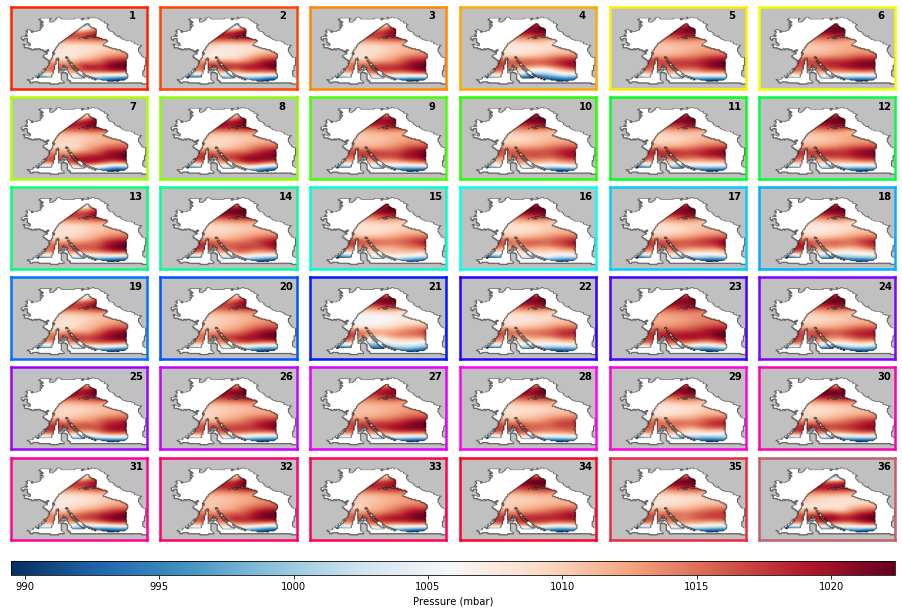

In [4]:
# Plot DWTs (data mean)
pred.Plot_DWTs('SLP', kind='mean', show=True);


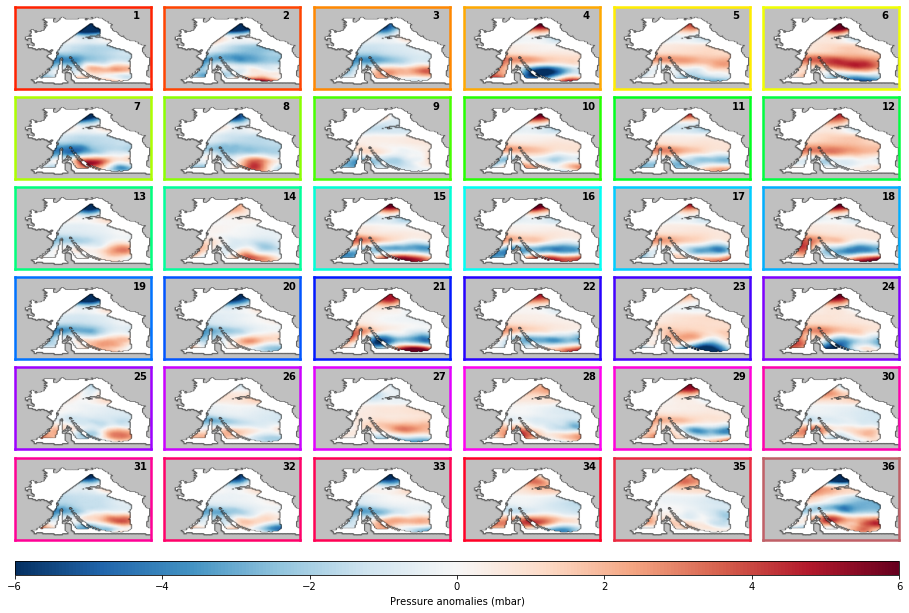

In [5]:
# Plot DWTs (data anomalies)
pred.Plot_DWTs('SLP', kind='anom', show=True);


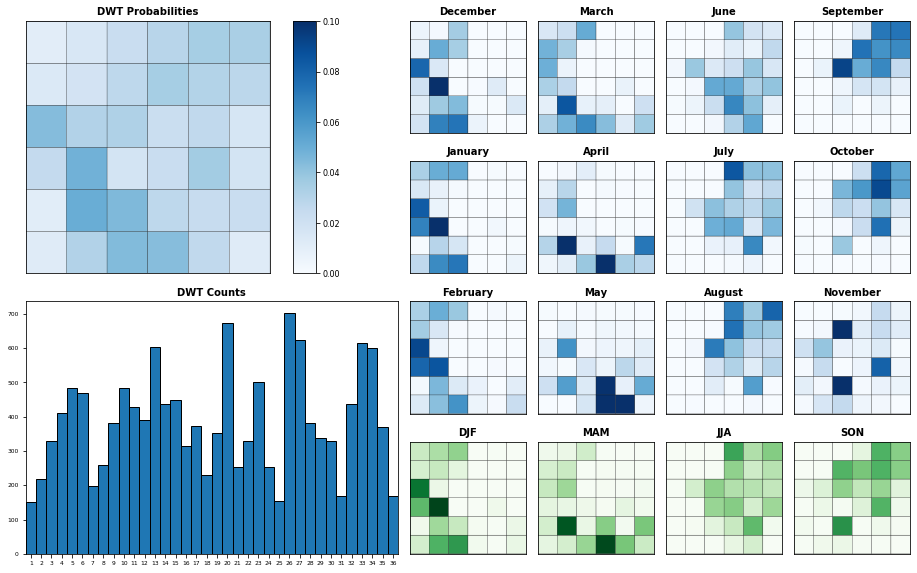

In [6]:
# Plot DWTs Probabilities
pred.Plot_DWTs_Probs();


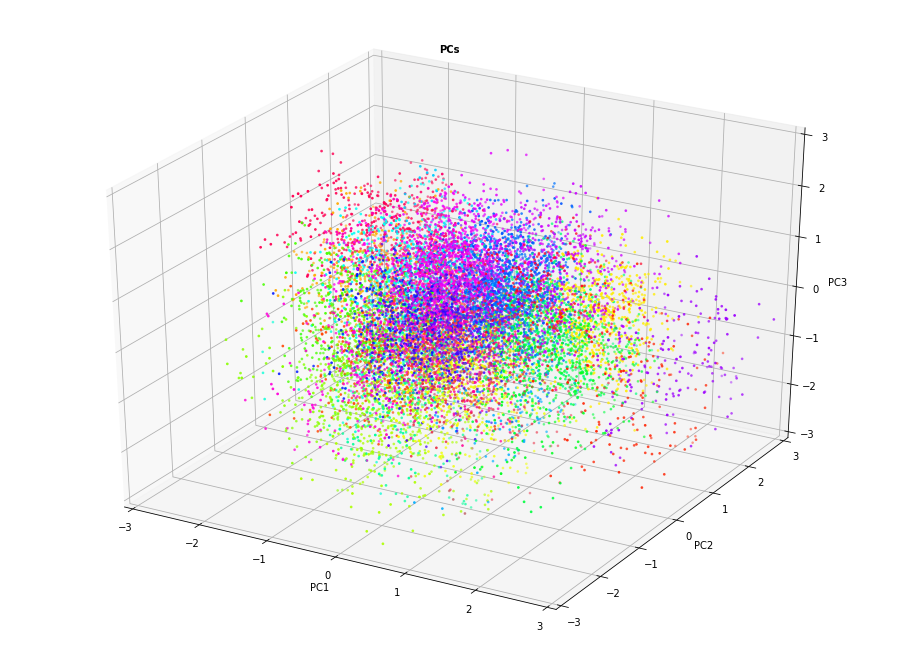

In [7]:
# Plot PC1, PC2, PC3 (3D)
pred.Plot_PCs_3D();


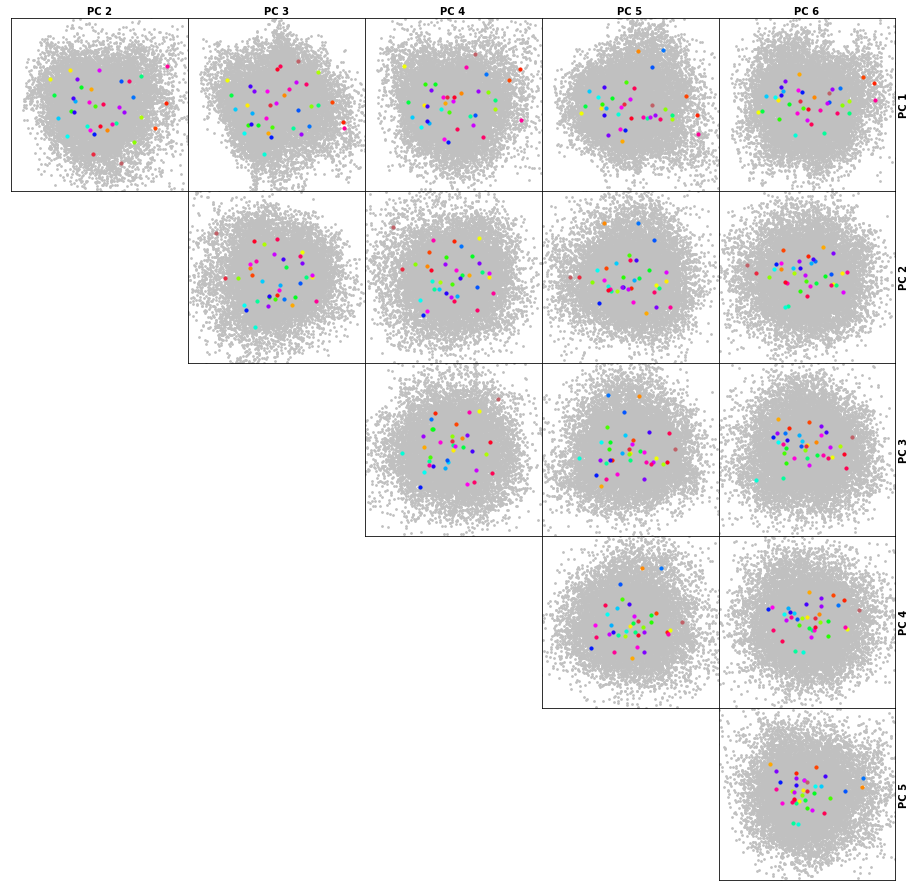

SystemExit: 

In [8]:
# Plot PCs DWT centroids
pred.Plot_DWT_PCs(n=6);



## ESTELA Predictor - Add Historical TCs

In [4]:
pred = Predictor(db.paths.site.ESTELA.pred_slp)

# Load predictor PCA, KMA
pred.Load()


In [5]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = TCs_r1_params.dmin_date.values[:]
storm_categs = TCs_r1_params.category.values[:]

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)

print(pred.KMA)

<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 13858, n_features: 107)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 ...
    cenEOFs             (n_clusters, n_features) float64 ...
    centroids           (n_clusters, n_features) float64 ...
    group_size          (n_clusters) int64 ...
    sorted_order        (n_clusters) int64 ...
    sorted_bmus         (n_components) int64 0 0 0 0 12 30 ... 25 25 25 25 25 25
    sorted_cenEOFs      (n_clusters, n_features) float64 ...
    sorted_centroids    (n_clusters, n_features) float64 ...
    time                (n_components) datetime64[ns] 1979-01-23 ... 2016-12-31
    sorted_bmus_storms  (n_components) int64 0 0 0 0 12 30 ... 25 25 25 25 25 25
Attributes:
    method:   regression guided
    alpha:    0.36


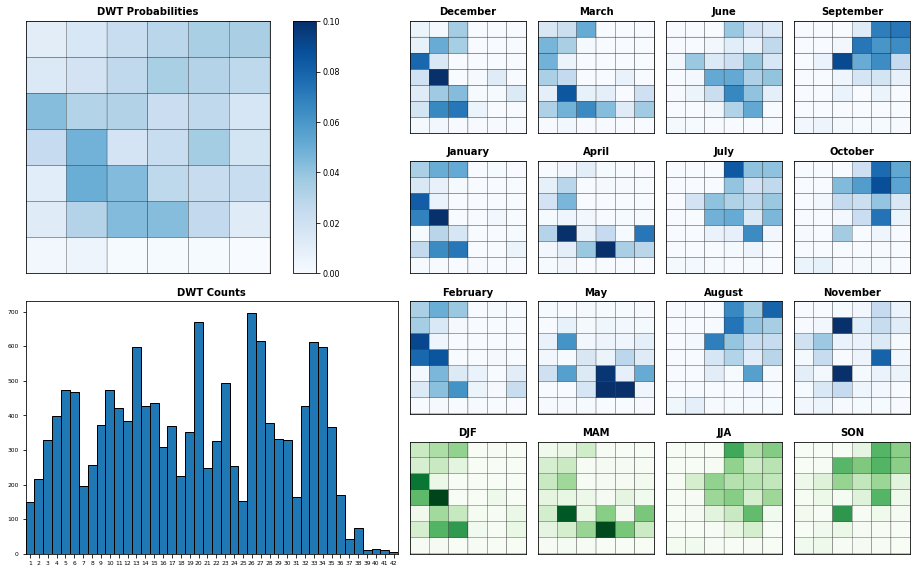

In [6]:
# Plot DWTs Probabilities with updated bmus
pred.Plot_DWTs_Probs(field='sorted_bmus_storms', n_clusters=42);


## Calculate hydrograps for nearshore waves at 3 locations (N, E, S)

In [5]:
# --------------------------------------
# Load nearshore hourly waves

WAVES_E = pd.read_pickle('/Users/albacid/Projects/TeslaKit_projects/inputs_Kwajalein/dataset_aggregated_E.pkl')
WAVES_S = pd.read_pickle('/Users/albacid/Projects/TeslaKit_projects/inputs_Kwajalein/dataset_aggregated_S.pkl')
WAVES_N = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/inputs_Kwajalein/wind_output.nc') # perfil 36

WAVES_E = WAVES_E.set_index('Time').to_xarray()
WAVES_S = WAVES_S.set_index('Time').to_xarray()
WAVES_N = WAVES_N.squeeze()

WAVES_E = WAVES_E.rename({'Time': 'time'})
WAVES_S = WAVES_S.rename({'Time': 'time'})
WAVES_N = WAVES_N.rename({'Time': 'time'})

WAVES_N = WAVES_N.rename_vars({"hs":"Hs", "tp":"Tp", 'dpm':'Dir'})  # rename vars


# --------------------------------------
# hourly runup

WAVES_runup_E_h = WAVES_runup_E.runup.interpolate_na(dim=('time'), method='linear')
WAVES_runup_S_h = WAVES_runup_S.runup.interpolate_na(dim=('time'), method='linear')
WAVES_runup_N_h = WAVES_runup_N.runup.interpolate_na(dim=('time'), method='linear')


# --------------------------------------
# Calculate intradaily MU TAU hydrographs

dic_Hydrographs_E, l_MU_TAU_E = pred.Calc_MU_TAU_Hydrographs_runup(WAVES_E, WAVES_runup_E_h)
dic_Hydrographs_S, l_MU_TAU_S = pred.Calc_MU_TAU_Hydrographs_runup(WAVES_S, WAVES_runup_S_h)
dic_Hydrographs_N l_MU_TAU_N = pred.Calc_MU_TAU_Hydrographs_runup(WAVES_N, WAVES_runup_N_h)


# store hydrographs MU TAU
db.Save_MU_TAU_hydrograms(l_MU_TAU_E, 'E')
db.Save_MU_TAU_hydrograms(l_MU_TAU_S, 'S')
db.Save_MU_TAU_hydrograms(l_MU_TAU_N, 'N')


{'bin00': <teslakit.intradaily.Hydrograph object at 0x11a89e470>, 'bin01': <teslakit.intradaily.Hydrograph object at 0x11b822518>, 'bin02': <teslakit.intradaily.Hydrograph object at 0x11b837978>, 'bin03': <teslakit.intradaily.Hydrograph object at 0x11b837f28>, 'bin04': <teslakit.intradaily.Hydrograph object at 0x11b838320>, 'bin05': <teslakit.intradaily.Hydrograph object at 0x11b838d68>, 'bin06': <teslakit.intradaily.Hydrograph object at 0x11b838908>, 'bin07': <teslakit.intradaily.Hydrograph object at 0x11b8381d0>, 'bin08': <teslakit.intradaily.Hydrograph object at 0x11b838c50>, 'bin09': <teslakit.intradaily.Hydrograph object at 0x11b838a58>, 'bin10': <teslakit.intradaily.Hydrograph object at 0x11b8384e0>, 'bin11': <teslakit.intradaily.Hydrograph object at 0x11b838898>, 'bin12': <teslakit.intradaily.Hydrograph object at 0x11b838e80>, 'bin13': <teslakit.intradaily.Hydrograph object at 0x11b838978>, 'bin14': <teslakit.intradaily.Hydrograph object at 0x11b838fd0>, 'bin15': <teslakit.intra

SystemExit: 

In [11]:
print(dic_Hydrographs_E['bin01'].Hs_hydro)

[[], [], [], [], array([1.77285615, 1.87771527, 1.99710234, 1.92024043, 1.90226972,
       1.88966977, 1.91600349, 1.88435135, 2.05168156, 2.18785961,
       2.20685794, 2.26601644, 2.24782833, 2.23773595, 2.24492788,
       2.21369635, 2.18953207, 2.20897028, 2.10656716, 2.06333211,
       2.05464512, 1.9646358 , 1.95592604, 2.004385  , 2.06991429,
       2.17761735, 2.15822283, 2.13461672, 2.12965676, 2.02085555,
       2.04650217, 2.05650367]), array([2.14523247, 2.16672367, 2.15582078, 2.12252316, 2.11835914,
       2.0740556 , 2.03743672, 2.01199169, 1.98428839, 1.96461417,
       2.0253256 , 2.07141357, 2.09033302, 2.05011875, 1.98820716,
       1.85870133, 1.74688708, 1.62948739, 1.56512177, 1.51329072,
       1.57036366, 1.46511499, 1.45803302, 1.45414452, 1.45563905,
       1.48247049, 1.58535305, 1.66273862, 1.77356294, 1.90568379,
       2.03798143, 2.19497092]), [], array([1.94799986, 1.79323137, 1.7306236 , 1.82585907, 1.91814807,
       1.96837881, 1.92889874, 1.88860694,

<xarray.Dataset>
Dimensions:      (time: 13880)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2016-12-31
Data variables:
    Hs           (time) float32 1.6662501 3.2777503 ... 1.4810834 1.6610836
    Tp           (time) float32 5.926146 8.379675 9.899439 ... 9.736651 8.821125
    Dir          (time) float32 75.36087 77.46667 ... 64.354164 66.84167
    sea_Hs       (time) float32 1.7357394 3.2762501 ... 1.3670835 1.5365833
    sea_Tp       (time) float32 5.922174 8.384167 9.058095 ... 9.16 7.784167
    sea_Dir      (time) float32 75.347824 77.416664 130.4762 ... 67.333336 70.5
    swell_1_Hs   (time) float64 nan nan 2.792 1.107 ... 0.942 0.9187 0.7647
    swell_1_Tp   (time) float64 nan nan 10.04 9.783 ... 9.76 9.66 9.673 10.22
    swell_1_Dir  (time) float64 nan nan 63.4 70.21 ... 68.0 69.0 69.33 74.67
    swell_2_Hs   (time) float64 nan nan 0.8766 0.5024 ... 0.1635 0.1375 0.1975
    swell_2_Tp   (time) float64 nan nan 8.428 8.584 ... 10.78 10.19 9.643 

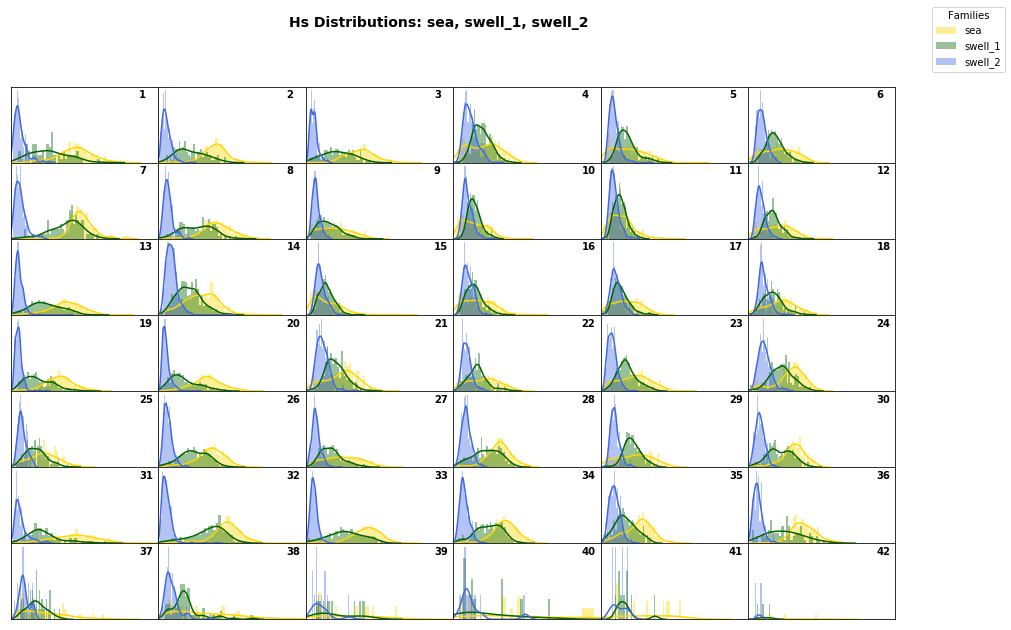

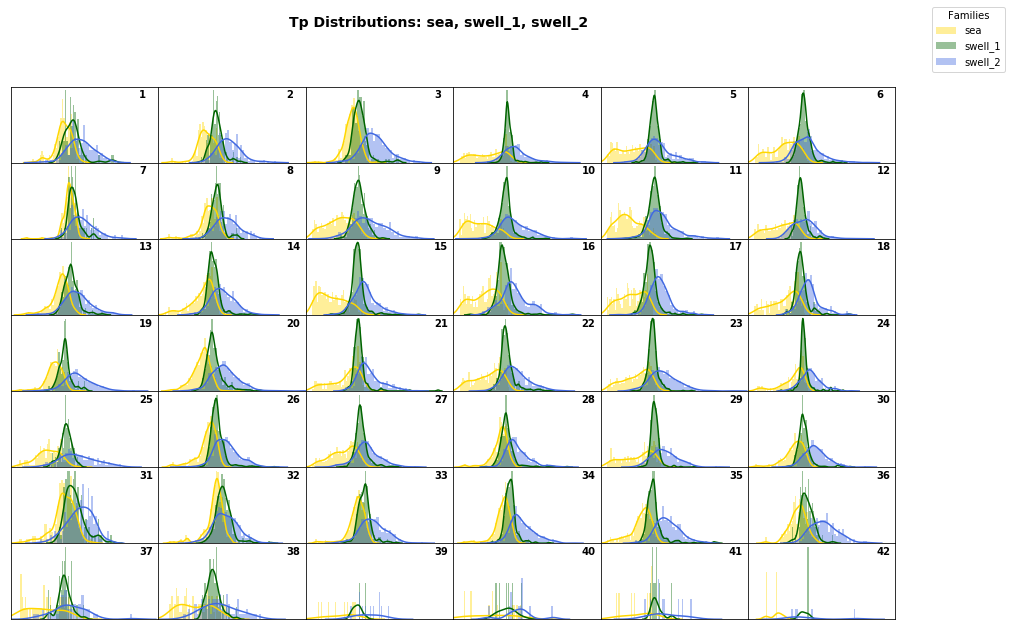

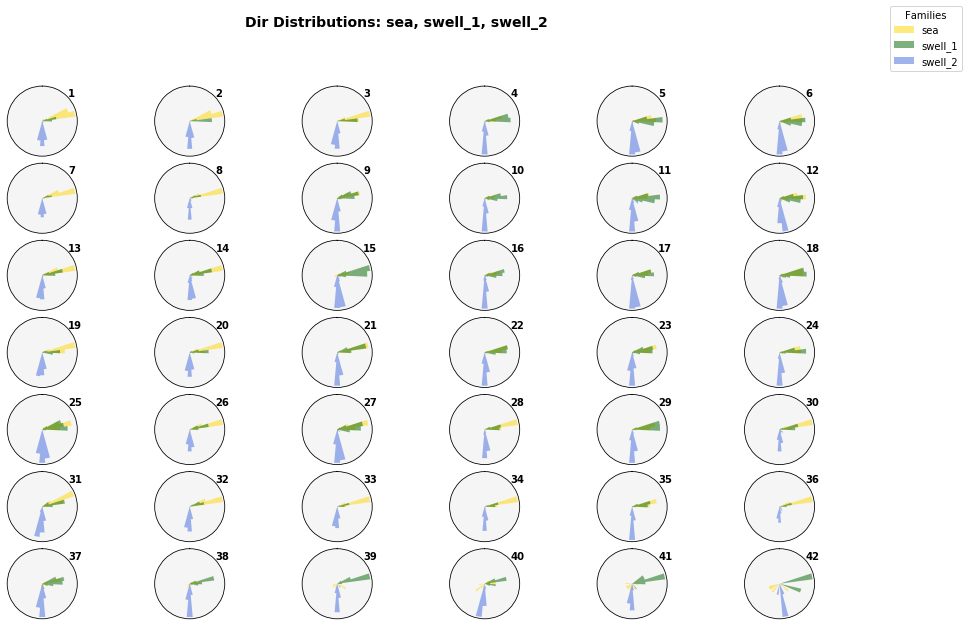

In [8]:
# Plot Waves Families by DWTs

# select time window and calculate daily mean
WAVES_d = WAVES.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()
print(WAVES_d)

# DWTs bmus
DWTs = pred.KMA
BMUS = xr.Dataset(
    {'bmus':(('time',), DWTs['sorted_bmus_storms'].values[:])},
    coords = {'time': DWTs.time.values[:]}
)
n_clusters = 42

# common dates
dates_common= xds_common_dates_daily([WAVES_d, DWTs])

# waves and bmus at common dates
WAVES_sel = WAVES_d.sel(time=dates_common)
bmus_sel = BMUS.sel(time=dates_common).bmus.values[:]

# Plot Waves Families by DWTs
Plot_Waves_DWTs(WAVES_sel, bmus_sel, n_clusters);


In [ ]:
sys.exit()

In [ ]:
# Plot MJO phases / DWTs Probabilities 

# num. MJO phases and DWTs
MJO_ncs = 8
DWT_ncs = 36

# MJO, DWTs historical data
MJO_hist, DWT_hist = db.Load_MJO_DWTs_Plots_hist()

# categories to plot
MJO_phase = MJO_hist.phase.values[:]
DWT_bmus =  DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl='DWTs Probabilities by MJO Phases (Historical)');


# plot DWTs conditional probabilities to each MJO, minus mean probabilities
Plot_Probs_WT_WT_anomaly(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl = 'DWTs anomaly Probabilities by MJO Phases (Historical)'
);
